# Markov Model for stochastic simulation of carsharing in Chicago

## Setup

In [782]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns. set(style='white', color_codes=True)
from collections import Counter
import pickle


# import holidays # https://pypi.org/project/holidays/
# import time

# import multiprocessing as mp
# import psutil

The dataset is huge, so for building the algorithms for cleanup and wrangling, **I will only load a small sample (2M rows)**

In [2]:
taxi_csv = '../data/Chicago_Taxi_Trips_2015.csv'
data = pd.read_csv(taxi_csv, nrows= 2000000)

We can get the name of the community areas from the wikipedia:

In [3]:
com_areas = pd.read_html('https://en.wikipedia.org/wiki/Community_areas_in_Chicago',header=0)
cols = ['Number','Community area','Neighborhoods']
_ = pd.DataFrame(columns=cols)
for df in com_areas:
    if df.columns.tolist() == cols:
        _ = pd.concat([_, df]).reset_index(drop = True)
com_areas = _.copy()
com_areas.Number = com_areas.Number.astype(int)
del _
com_areas.head()

,Number,Community area,Neighborhoods
0,8,Near North Side,Cabrini–Green The Gold Coast Goose Island Magn...
1,32,Loop,Loop Near East Side South Loop West Loop Gate
2,33,Near South Side,Dearborn Park Printer's Row South Loop Prairie...
3,5,North Center,Horner Park Roscoe Village
4,6,Lake View,Boystown Lake View East Graceland West South E...


In [4]:
data.info(memory_usage='deep') # By setting memory_usage parameter to 'deep', we get the actual memory ussage instead of approximate values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 23 columns):
Trip ID                       object
Taxi ID                       object
Trip Start Timestamp          object
Trip End Timestamp            object
Trip Seconds                  float64
Trip Miles                    float64
Pickup Census Tract           float64
Dropoff Census Tract          float64
Pickup Community Area         float64
Dropoff Community Area        float64
Fare                          object
Tips                          object
Tolls                         object
Extras                        object
Trip Total                    object
Payment Type                  object
Company                       object
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Pickup Centroid Location      object
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
Dropoff Centroid  Location    object
dtypes: float64(10), objec

## Data Cleaning

As data cleaning and imputation is not the purpose of this example, I won't get into it nor spend much time doing it. there are many things that could be done but today I will drop the records with quality problems. 

In [6]:
data.columns#.tolist()

Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')

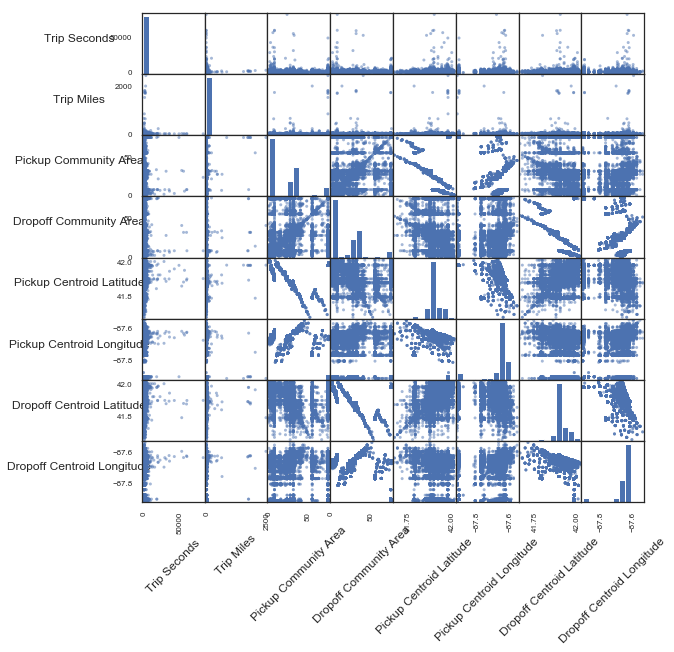

In [7]:
sm = pd.plotting.scatter_matrix(data[['Trip Start Timestamp', 'Trip End Timestamp','Trip Seconds', 'Trip Miles',
                                      'Pickup Community Area','Dropoff Community Area',
                                      'Pickup Centroid Latitude','Pickup Centroid Longitude',
                                      'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',]].sample(100000), figsize=(9,9))
#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
#To offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]
# plt.tight_layout()
plt.show()

**Geographical data:**
* **Pickup and Dropoff Census Tract:** Many values are missing. However, we could make use of other columns, such as latitude and longitude, community areas, etc. (when present), to try and find estimates for the actual values. For now, we won't make use of this column and we will limit to the "Community Area" level

* **Pickup and Dropoff coordinate pairs:** A similar strategy could be used. However, these values have been rounded to centroids, so are not the real values. Moreover, it has been decided to work at the Community Area level, so these won't be determinant for the analysis. However, they can be used for visualizations, to do that, we could replace the missing values with the most common ones on the Area. For now, it won't be necessary as those rows missing those values, are also missing the community area.

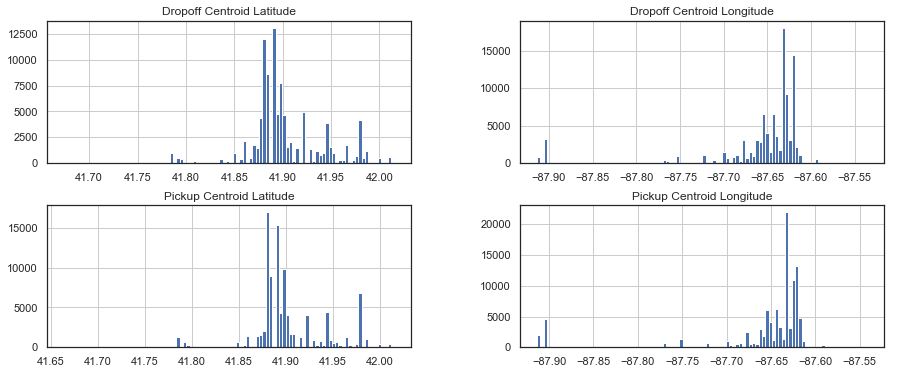

In [8]:
data[['Pickup Centroid Latitude','Pickup Centroid Longitude',
      'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']].sample(100000).hist( bins=100, figsize=(15,6) )
plt.show()

* **Pickup and Dropoff Community Area:** As the idea is to work at the "Community Area" level. It would be a good idea to try to find some of these missing values. However, the carsharing model in Chicago is only allowed on a restricted zone. Therefore, we'll try to limit the analysis to those trips moving within the operation zone. <br>
included_areas = [3, 4, 16, 21, 22, 24, 28, 8, 32, 33, 31] 

In [9]:
_ = data.sample(100000)
_[['Pickup Census Tract','Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Pickup Centroid Location', 'Pickup Centroid Latitude','Pickup Centroid Longitude',
      'Dropoff Centroid  Location','Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']].isnull().sum() / len(_)

Pickup Census Tract           0.27184
Dropoff Census Tract          0.27755
Pickup Community Area         0.00677
Dropoff Community Area        0.02833
Pickup Centroid Location      0.00675
Pickup Centroid Latitude      0.00675
Pickup Centroid Longitude     0.00675
Dropoff Centroid  Location    0.02637
Dropoff Centroid Latitude     0.02637
Dropoff Centroid Longitude    0.02637
dtype: float64

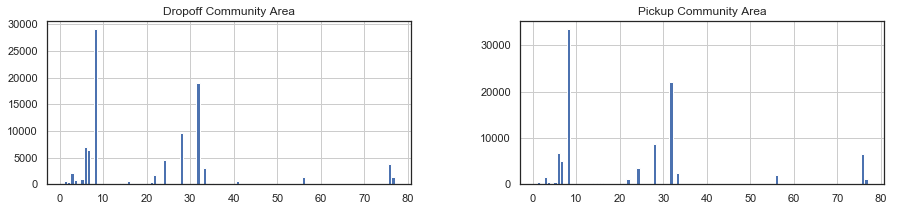

In [10]:
data[['Pickup Community Area','Dropoff Community Area']].sample(100000).hist( bins=100, figsize=(15,3) )
plt.show()

In [11]:
def prepare_geodata(df):
    df = df.copy()
    # Drop records where community areas and coordinate pairs are missing
    df = df[(~df.Pickup_Community_Area.isnull()) & (~df.Dropoff_Community_Area.isnull())]
    df = df[(~df.Pickup_Centroid_Latitude.isnull()) & (~df.Pickup_Centroid_Longitude.isnull())]
    df = df[(~df.Dropoff_Centroid_Latitude.isnull()) & (~df.Dropoff_Centroid_Longitude.isnull())]    
    return df


**Time and Distance Data:**
* **Start and end timestamps:** Only a small portion of data is missing. For now, let's not bother with fixing this. On the other side, these values have been rounded to their nearest quarter, let's shift Trip_End_Timestamp moving using the "Trip_Seconds" value. It won't be the actual value (as the start time would not be the real one) but at least it will be and ending time that represents the actual trip length.

* **"Trip Seconds":** Let's get rid of those null values as well as those with 0 seconds length. On top of that, let's drop those with over 1 hour. Also, people hardly rent a car for less than something around 10 minutes, so let's drop those trips under 5 minutes, to give it some room.
* **Trip Miles":** The average taxi trip on the dataset is around 3.3 miles. However, there are a few values way over that. Let's drop those values over 6 miles.

In [12]:
_ = data.sample(100000)
_[['Trip Start Timestamp','Trip End Timestamp','Trip Seconds', 'Trip Miles']].isnull().sum() / len(_)

Trip Start Timestamp    0.00000
Trip End Timestamp      0.00013
Trip Seconds            0.00021
Trip Miles              0.00000
dtype: float64

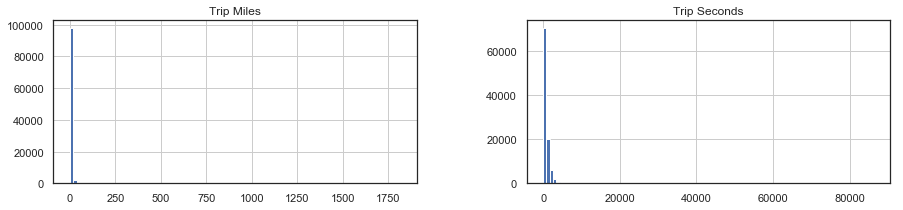

In [13]:
data[['Trip Seconds', 'Trip Miles']].sample(100000).hist( bins=100, figsize=(15,3) )
plt.show()

In [14]:
data['Trip Miles'].describe()

count    1.999996e+06
mean     3.275575e+00
std      1.669003e+01
min      0.000000e+00
25%      2.000000e-01
50%      1.200000e+00
75%      3.000000e+00
max      3.130000e+03
Name: Trip Miles, dtype: float64

In [15]:
data['Trip Seconds'].describe()

count    1.999494e+06
mean     8.041342e+02
std      9.655227e+02
min      0.000000e+00
25%      3.600000e+02
50%      6.000000e+02
75%      9.600000e+02
max      8.634000e+04
Name: Trip Seconds, dtype: float64

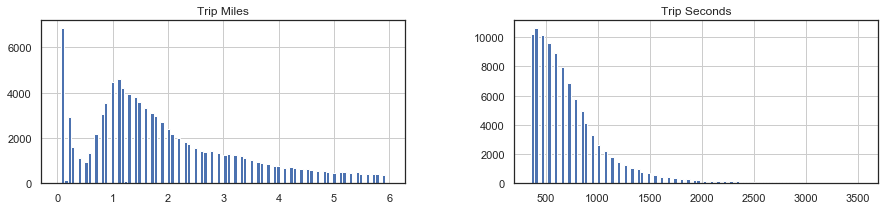

In [16]:
data[['Trip Seconds', 'Trip Miles']].loc[(data['Trip Seconds'] < 3600) & (data['Trip Seconds'] > 300) & 
                                         (data['Trip Miles'] < 6) & (data['Trip Miles'] > 0)].sample(100000).hist( bins=100, figsize=(15,3) )
plt.show()

In [103]:
# included_areas

[3, 4, 16, 21, 22, 24, 28, 8, 32, 33, 31]

In [17]:
def prepare_time_and_distance(df):
    global mean_demandsupply
    df = df.copy()    
    df['Trip_Start_Timestamp'] = pd.to_datetime(df['Trip_Start_Timestamp']) # Convert to datetime
    df = df.loc[df.Trip_Start_Timestamp < pd.Timestamp('2016-01-01 00:00:00')] # Keep only data for 2015
    df['Pickup_Community_Area'] = df.Pickup_Community_Area.astype(int)
    df['Dropoff_Community_Area'] = df.Dropoff_Community_Area.astype(int)
    df['start_hour'] = df.Trip_Start_Timestamp.dt.hour
    df['day_of_week'] = df.Trip_Start_Timestamp.dt.weekday
    df['is_weekend'] = [1 if day in [5,6] else 0 for day in df['day_of_week']]
    df['date'] = df.Trip_Start_Timestamp.dt.date
    
    average_daily_trips(df[['Trip_Start_Timestamp','start_hour','is_weekend','date']]) # Count the average daily trips on the dataset before filtering out rows
    df['Trip_Duration'] = pd.to_timedelta(df.Trip_Seconds, unit='s') # Create Trip_Duration
    df['Trip_End_Timestamp'] =  df.Trip_Start_Timestamp + df.Trip_Duration # Modify Trip_End_Timestamp to reflect the trip duration
    
    df['end_timeofday'] = df.Trip_End_Timestamp.dt.hour + df.Trip_End_Timestamp.dt.minute / 60 
    
    mean_demandsupply = mean_demandsupply_by_area(df[['Trip_Start_Timestamp','Dropoff_Community_Area','Pickup_Community_Area','start_hour','Trip_Seconds','is_weekend','end_timeofday','date']],
                                                  store_path = '../processed_data/mean_demandsupply.csv',return_df = True)
    
    hourly_demand_distribution(df[['start_hour','is_weekend','Pickup_Community_Area','date']])
    
    hourly_trips_between_areas(df[['date','start_hour','Pickup_Community_Area','Dropoff_Community_Area',
                               'Trip_Seconds','is_weekend']])    
    
    df = df.loc[(df['Trip_Seconds'] < 3600) & (df['Trip_Seconds'] > 300) & 
                (df['Trip_Miles'] < 6) & (df['Trip_Miles'] > 0)]
    df = df[(df.Trip_Seconds != 0) & (~df.Trip_Seconds.isnull())] # Drop rows where Trip_Seconds == 0
    df['start_timeofday'] = df.start_hour + df.Trip_Start_Timestamp.dt.minute / 60
    df['month'] = df.Trip_Start_Timestamp.dt.month
    df['quarter'] = df.Trip_Start_Timestamp.dt.quarter ##
    # df["year"] = df.pickup_datetime.dt.year
    return df


**Other Data:** <br>
Other data, such as 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip_Total', 'Payment_Type', and 'Company'; won't be required for the purpose of this project, so let's not get into that.

--------------------

Now, in order to make the dataset smaller and faster to work with, let's get rid of those columns we don't plan to use:

In [18]:
data.shape

(2000000, 23)

In [19]:
# Begin by droping the columns that won't be required. This way some memory will be released and computation will speed-up.
columns_to_keep = ['Trip Start Timestamp', 'Trip End Timestamp','Trip Seconds', 'Trip Miles',
                   'Pickup Community Area','Dropoff Community Area',
                   'Pickup Centroid Latitude','Pickup Centroid Longitude',
                   'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',]
data = data[columns_to_keep] # Keep only the columns that will be needed

In [20]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
Trip Start Timestamp          object
Trip End Timestamp            object
Trip Seconds                  float64
Trip Miles                    float64
Pickup Community Area         float64
Dropoff Community Area        float64
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
dtypes: float64(8), object(2)
memory usage: 423.4 MB


As you can see, the memory usage decreased by a lot after dropping those columns.

### Data Cleaning Functions:

Now, let's build those function for data cleanup

In [21]:
def average_daily_trips(df):
    '''
        Calculates the mean daily trips. 
        It's being run during clean-up so the trips that are filtered out for calculations are accounted for on this data
    '''
    global mean_weekday_trips, mean_weekend_trips
    df = df.copy()
#     df['date'] = df.Trip_Start_Timestamp.dt.date
    df = df.groupby(['date',],as_index=False).agg({'start_hour': 'count', 'is_weekend':'mean'})\
            .rename(index=str, columns={'start_hour':'trips'}).groupby(['is_weekend',],as_index=False)\
            .mean()
    mean_weekday_trips = df.loc[df.is_weekend == 0, 'trips'].reset_index(drop = True)[0]
    mean_weekend_trips = df.loc[df.is_weekend == 1, 'trips'].reset_index(drop = True)[0]
    print('Mean Daily Trips on Weekdays:', mean_weekday_trips)
    print('Mean Daily Trips on Weekends:', mean_weekend_trips)
    
# average_daily_trips(data)

In [22]:
def mean_demandsupply_by_area(df, store_path, com_areas = com_areas, return_df = False):
    '''
        Function to extract the data to plot the mean demand and supply of vehicles by area.
        It's being run during clean-up so the trips that are filtered out for calculations are accounted for on this data
    '''
    df = df.copy()
    df = df.dropna()
    df_from, df_to = df.copy(), df.copy()
    df_from = df_from.groupby(['date','Pickup_Community_Area','start_hour'],as_index=False)\
            .agg({'Trip_Seconds': 'count', 'is_weekend':'mean'})\
            .rename(index=str, columns={'Trip_Seconds':'trips_from','Pickup_Community_Area': 'area','start_hour':'hour'})
    df_to['end_timeofday'] = df_to.end_timeofday.astype('int')
    df_to = df_to.groupby(['date','Dropoff_Community_Area','end_timeofday'],as_index=False)\
            .agg({'Trip_Seconds': 'count', 'is_weekend':'mean'})\
            .rename(index=str, columns={'Trip_Seconds':'trips_to','Dropoff_Community_Area': 'area','end_timeofday':'hour'})
    merged = pd.merge(df_from,df_to, how='outer', on=['date','area','hour','is_weekend']).fillna(0)
    del df_from, df_to
    merged['net_trips'] = merged.trips_to - merged.trips_from
    merged = merged.groupby(['area','hour','is_weekend'],as_index=False)\
            .agg({'net_trips':['mean','std']})
    merged.columns = [col_0 if len(col_1) == 0 else col_0 + '_' + col_1 for col_0,col_1 in zip(merged.columns.get_level_values(0).tolist(), merged.columns.get_level_values(1).tolist())]
    merged['abs_trips'] = abs(merged.net_trips_mean)
    merged['sign'] = [1 if trip >= 0 else -1 for trip in merged.net_trips_mean]
    merged = pd.merge(merged, com_areas[['Number','Community area']] , how = 'left', left_on='area', right_on='Number')
    merged.drop(columns = ['Number'], inplace  = True)
    merged.to_csv(store_path, index=False)
    if return_df:
        return merged
# mean_demandsupply = mean_demandsupply_by_area(data, store_path = '../processed_data/mean_demandsupply.csv',return_df = True)
# mean_demandsupply.head()

In [23]:
def hourly_demand_distribution(df, store_path = '../processed_data/hourly_demand_dist.csv', return_df = False):
    '''
        Data for plotting the demand distribution per hour
        It's being run during clean-up so the trips that are filtered out for calculations are accounted for on this data
    '''
    global hourly_demand_dist_df
    df = df.copy()
    df = df.groupby(['date', 'start_hour'], as_index=False).agg({'is_weekend':'mean','Pickup_Community_Area':'count'})\
            .rename(index=str, columns={'Pickup_Community_Area':'trips'})
    df = df.groupby(['start_hour', 'is_weekend'], as_index=False).agg({'trips':['mean','std']})
    df.columns = [col_0 if len(col_1) == 0 else col_0 + '_' + col_1 for col_0,col_1 in zip(df.columns.get_level_values(0).tolist(), df.columns.get_level_values(1).tolist())]
    hourly_demand_dist_df = df.copy()
    if return_df:
        return df
# hourly_demand_distribution(data[['start_hour','is_weekend','Pickup_Community_Area','date']])

In [24]:
def hourly_trips_between_areas(df, store_path = '../processed_data/hourly_trips_between_areas.csv', com_areas = com_areas, return_df = False):
    '''
        Function to extract the data to plot the mean hourly demand of trips by area.
        It's being run during clean-up so the trips that are filtered out for calculations are accounted for on this data
    '''
    global hourly_trips_between_areas_df
    df = df.copy()
    df = df.dropna()
    df = df.groupby(['date','start_hour','Pickup_Community_Area','Dropoff_Community_Area'],as_index=False)\
            .agg({'Trip_Seconds': 'count', 'is_weekend':'mean'})\
            .rename(index=str, columns={'Trip_Seconds':'trips','Pickup_Community_Area': 'from_area',
                                        'Dropoff_Community_Area':'to_area','start_hour':'hour'})
    df = df.groupby(['hour','from_area','to_area','is_weekend'],as_index=False)\
            .agg({'trips':['mean','std']})
    
    df.columns = [col_0 if len(col_1) == 0 else col_0 + '_' + col_1 for col_0,col_1 in zip(df.columns.get_level_values(0).tolist(), df.columns.get_level_values(1).tolist())]
    
    df = pd.merge(df, com_areas[['Number','Community area']] , how = 'left', left_on='from_area', right_on='Number')\
        .rename(index=str, columns={'Community area':'from'}).drop(columns = ['Number'])
    df = pd.merge(df, com_areas[['Number','Community area']] , how = 'left', left_on='to_area', right_on='Number')\
        .rename(index=str, columns={'Community area':'to'}).drop(columns = ['Number'])
    
    hourly_trips_between_areas_df = df.copy()
    df.to_csv(store_path, index=False)

    if return_df:
        return df
# hourly_trips_between_areas(data)
# hourly_trips_between_areas_df.head()

In [25]:
included_areas = [3, 4, 16, 21, 22, 24, 28, 8, 32, 33, 31] # The company only has permission to park cars within these areas

def data_cleanup(df, included_areas):
    print('DF shape',df.shape)
    rows, columns = df.shape
    df.columns = [c.replace(' ','_') for c in df.columns]
    df.columns = [c.replace('__','_') for c in df.columns]
    df = df.loc[(df.Dropoff_Community_Area.isin(included_areas)) & 
                (df.Pickup_Community_Area.isin(included_areas))]
    print('Initial number of trips within included areas:',df.shape[0])
    df = prepare_time_and_distance(df)
    df = prepare_geodata(df)
    # Check and warn if null values persist
    _ = df.isnull().sum() / len(df)
    _ = _[_ > 0]
    if len(_) > 0:
        print('Null values have been found:')
        print(_)
    
    print('Resulting DF shape',df.shape)
    
    df = df.reset_index(drop = True)
    
    return df

In [26]:
del data
data = pd.read_csv(taxi_csv, usecols=columns_to_keep) #, nrows=10000000

Now that the functions are ready, I'm loading the entire dataset.

In [27]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27401541 entries, 0 to 27401540
Data columns (total 10 columns):
Trip Start Timestamp          object
Trip End Timestamp            object
Trip Seconds                  float64
Trip Miles                    float64
Pickup Community Area         float64
Dropoff Community Area        float64
Pickup Centroid Latitude      float64
Pickup Centroid Longitude     float64
Dropoff Centroid Latitude     float64
Dropoff Centroid Longitude    float64
dtypes: float64(8), object(2)
memory usage: 5.7 GB


Before processing, the dataset was using over 5GB of memory.

In [28]:
data = data_cleanup(data, included_areas = included_areas)

DF shape (27401541, 10)
Initial number of trips within included areas: 13741347
Mean Daily Trips on Weekdays: 39410.96168582376
Mean Daily Trips on Weekends: 33217.83653846154
Resulting DF shape (7792308, 19)


In [29]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7792308 entries, 0 to 7792307
Data columns (total 19 columns):
Trip_Start_Timestamp          datetime64[ns]
Trip_End_Timestamp            datetime64[ns]
Trip_Seconds                  float64
Trip_Miles                    float64
Pickup_Community_Area         int32
Dropoff_Community_Area        int32
Pickup_Centroid_Latitude      float64
Pickup_Centroid_Longitude     float64
Dropoff_Centroid_Latitude     float64
Dropoff_Centroid_Longitude    float64
start_hour                    int64
day_of_week                   int64
is_weekend                    int64
date                          object
Trip_Duration                 timedelta64[ns]
end_timeofday                 float64
start_timeofday               float64
month                         int64
quarter                       int64
dtypes: datetime64[ns](2), float64(8), int32(2), int64(5), object(1), timedelta64[ns](1)
memory usage: 1.3 GB


After processing, we are using only about 1.3GB

In [30]:
data.head()

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,start_hour,day_of_week,is_weekend,date,Trip_Duration,end_timeofday,start_timeofday,month,quarter
0,2015-05-24 15:15:00,2015-05-24 15:24:00,540.0,0.1,24,28,41.901207,-87.676356,41.874005,-87.663518,15,6,1,2015-05-24,00:09:00,15.400000,15.25,5,2
1,2015-12-11 20:30:00,2015-12-11 20:38:00,480.0,1.1,8,32,41.892508,-87.626215,41.880994,-87.632746,20,4,0,2015-12-11,00:08:00,20.633333,20.50,12,4
2,2015-07-22 19:30:00,2015-07-22 19:37:00,420.0,1.0,28,32,41.879255,-87.642649,41.880994,-87.632746,19,2,0,2015-07-22,00:07:00,19.616667,19.50,7,3
3,2015-07-29 19:45:00,2015-07-29 19:56:00,660.0,1.5,28,8,41.885300,-87.642808,41.892042,-87.631864,19,2,0,2015-07-29,00:11:00,19.933333,19.75,7,3
4,2015-10-13 21:15:00,2015-10-13 21:26:00,660.0,0.2,28,33,41.885281,-87.657233,41.859350,-87.617358,21,1,0,2015-10-13,00:11:00,21.433333,21.25,10,4


In [786]:
with open('../processed_data/clean_data.pkl', 'wb') as handle:
    pickle.dump(data, handle)

Now that the cleanup is ready, we can move to modeling.

## Building Transition Matrices

Users transportation patterns are clearly different on weekdays and weekends. People have different destinations and schedules. Therefore, I'm building two different sets of transition matrices. One for weekdays and another one for weekends.

Each set will have the following groups of matrices:

**1. Area transition matrices:** 
* 24 matrices (one per each hour of the day), containing the transition probabilities from/to each different community area.

**2. Average trip times:**
* 24 matrices (one per each hour of the day), storing the average trip times from/to each community area.

**3. Average Distance between areas:**
* To simplify things, we will stick with the average distance. We will need 1 matrix with this data.

**4. Daily Demand Distribution:**
* Demand for cars varies not only on each hour of the day, but also on the different areas *(see plot below)*, so a matrix will hold the demand distribution per each time_window on each area. For time windows, we will use 15 minute chunks, for a total of 96 windows per day.
* A vector will store the demand distribution per area through the day. 

C:\Users\galvi\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


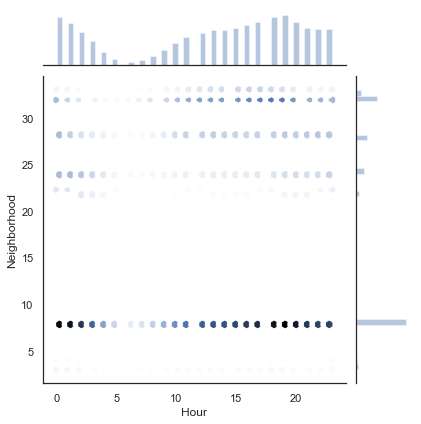

In [31]:
_ = data.loc[(data.is_weekend == True)]\
    .rename(index=str, columns={'Pickup_Community_Area':'Neighborhood','start_hour':'Hour'})
_['Neighborhood'] = _.Neighborhood.astype('category')
g = sns.jointplot(x='Hour',y='Neighborhood',data=_, kind='hex', stat_func = None)
g

The following code will loop through every hour, pickup area, and dropoff area to create the matrices.

In [32]:
def create_time_windows():
    time_windows = list(range(0,2400,25)) # Create the 15 minutes time windows (0.25 hours, remember range doesn't take decimals)
    time_windows = [x / 100 for x in time_windows] 
    return time_windows

In [33]:
def create_matrices(weekend = False):
    # Initialize dictionary to store the matrices
    matrix_dict = {'hour_area_transition': [], 'hour_trip_time': []}

    # List of areas included in the pilot:
    included_areas = sorted(data.Pickup_Community_Area.append(data.Dropoff_Community_Area).unique().tolist())
    
    # 1 and 2. Area transition and time matrices
    for pick_hr in range(24):
        tran_stack =  np.zeros((0,len(included_areas))) # initialize empty list
        time_stack =  np.zeros((0,len(included_areas))) # initialize empty list
        for pick_area in included_areas: # Loop through all the areas where cars can be picked
            # For each area, select all trips looping through each hour. Then, group by drop area. Finally, aggregate the values.
            _ = data.loc[(data.is_weekend == weekend) & 
                         (data.Pickup_Community_Area == pick_area) & (data.start_hour == pick_hr)].\
                    groupby(['Dropoff_Community_Area'],as_index=False).\
                    agg({'start_hour': 'count','Trip_Miles':'mean','Trip_Seconds':'mean'}).\
                    rename(index=str, columns={'start_hour':'trips','Trip_Miles':'avg_distance','Trip_Seconds':'avg_time',})
            transitions_list = [] # Initialize empty list for transitions from this area at this hour
            trip_time_list = [] # Initialize empty list for mean trip times from this area to each other area at this hour
            for drop_area in included_areas: # Loop through all the areas where cars can be dropped
                hour_area_trips = _.loc[_.Dropoff_Community_Area == drop_area].trips # Number of trips within the areas at that hour
                if len(hour_area_trips) > 0: # Check if there were trips at that time between the pair of areas. If so...
                    transitions_list.append(hour_area_trips[0] / _.trips.sum()) # Store the probability for each trip happening
                else: # If there were no trips, set the probability to 0. In real life, it might be a low probability but probably not 0...
                    transitions_list.append(0)

                trip_seconds = _.loc[_.Dropoff_Community_Area == drop_area].avg_time # Average trip time for trips within the areas at that hour
                if len(trip_seconds) > 0: # Check if there were trips at that time between the pair of areas. If so...
                    trip_time_list.append(trip_seconds[0])
                else: # If there were no trips, set the trip average duration to nan
                    trip_time_list.append(np.NAN)

            tran_stack = np.vstack([tran_stack, transitions_list]) # Stack data for current drop_area
            time_stack = np.vstack([time_stack, trip_time_list]) # Stack data for current drop_area
        matrix_dict['hour_area_transition'].append(tran_stack) # Store vector for current hour
        matrix_dict['hour_trip_time'].append(time_stack) # Store vector for current hour
    
    # 3. Average Distance between areas
    dist_stack =  np.zeros((0,len(included_areas))) # initialize empty list
    for pick_area in included_areas: 
        distance_list = [] # Initialize empty list for trips from current pick_area
        # For each pickup area, aggregate distance. Distance will be the same regardless of it being a weekday or a weekend
        _ = data.loc[(data.Pickup_Community_Area == pick_area)].\
                groupby(['Dropoff_Community_Area'],as_index=False).\
                agg({'Trip_Miles':'mean'}).\
                rename(index=str, columns={'Trip_Miles':'avg_distance'})
        for drop_area in included_areas: # Loop through all the Dropoff_Community_Area
            distance = _.loc[_.Dropoff_Community_Area == drop_area].avg_distance
            if len(distance) > 0: # Check that we have mean distance for this route
                distance_list.append(distance[0])
            else: # If not, then replace with a NAN
                distance_list.append(np.NAN)
            
        dist_stack = np.vstack([dist_stack, distance_list])
    matrix_dict['distances'] = dist_stack
    
    # 4.1 Demand Distribution per window
    time_windows = create_time_windows()
    demand_stack =  np.zeros((0,len(time_windows))) # initialize empty list
    for pick_area in included_areas: # Loop through each area
        # Count the number of registered trips per every hour on current pick_area. It matters if it is weekend or not.
        _ = data.loc[(data.is_weekend == weekend) & 
                     (data.Pickup_Community_Area == pick_area)].\
                groupby(['start_timeofday'],as_index=False).\
                agg({'start_hour': 'count'}).\
                rename(index=str, columns={'start_hour':'trips'})
        demand_dist = [] # initialize an empty demand list
        for window in time_windows: # Loop through the 96 time windows storing the demand for each one
            window_trips = _.loc[_.start_timeofday == window].trips # Number of trips within window
            if len(window_trips) > 0: # If there are trips within current window... 
                demand_dist.append(window_trips[0]/sum(_.trips)) # Normalize the data to a (0,1) distribution
            else:
                demand_dist.append(0) # If no trips were found, insert 0
        demand_stack = np.vstack([demand_stack, demand_dist]) # Store vector for current window
    matrix_dict['demand_dist_per_window'] = demand_stack
    
    # 4.2 Demand Distribution per area
    _ = data.loc[(data.is_weekend == weekend)].groupby(['Pickup_Community_Area'],as_index=False)\
            .agg({'start_hour': 'count'})\
            .rename(index=str, columns={'start_hour':'trips'})
    demand_dist = []
    for pick_area in included_areas:    
        demand_dist.append(_.loc[_.Pickup_Community_Area == pick_area].trips[0]/sum(_.trips))
    matrix_dict['demand_dist_per_area']=np.asarray(demand_dist)
    
    
    return matrix_dict

# create_matrices(weekend=False)['demand_dist_per_area']

In [34]:
weekday_matrices = create_matrices(weekend=False)
weekend_matrices = create_matrices(weekend=True)

### Created Matrices:

Below, examples of the created matrices can be found.

**1. Area transition matrices:** 

The transition matrices have been created for the different areas of the city where the pilot will be running, one set for weekends and another one for weekdays. 

An example can be seen below for 09:00 AM on a weekday:

In [35]:
_ = pd.DataFrame(weekday_matrices['hour_area_transition'][9], index=included_areas, columns=included_areas)
print('You can see that the probability for a trip to end in area 8, given that began in area 3 at Between 9 and 10 AM, is:',_.loc[3,8])
_

You can see that the probability for a trip to end in area 8, given that began in area 3 at Between 9 and 10 AM, is: 0.037853577371048254


,3,4,16,21,22,24,28,8,32,33,31
3,0.172421,0.055116,0.415765,0.031406,0.006864,0.012895,0.024126,0.037854,0.000208,0.240017,0.003328
4,0.223226,0.354839,0.080000,0.043871,0.030968,0.041290,0.046452,0.032258,0.001290,0.140645,0.005161
16,0.002604,0.000389,0.195651,0.000197,0.000654,0.002931,0.018092,0.157560,0.001000,0.546283,0.074639
21,0.152964,0.158700,0.074570,0.183556,0.099426,0.107075,0.091778,0.074570,0.001912,0.053537,0.001912
22,0.034602,0.079585,0.228374,0.055363,0.089965,0.107266,0.114187,0.162630,0.006920,0.121107,0.000000
24,0.015038,0.013534,0.312281,0.011028,0.011529,0.047619,0.078195,0.190476,0.002506,0.315288,0.002506
28,0.003415,0.001138,0.339432,0.001870,0.002440,0.016996,0.041961,0.195170,0.002684,0.385216,0.009677
8,0.000350,0.000147,0.391235,0.000090,0.000508,0.002552,0.015210,0.086316,0.004268,0.459834,0.039488
32,0.007519,0.002506,0.177945,0.000000,0.000000,0.012531,0.025063,0.290727,0.030075,0.325815,0.127820
33,0.000764,0.000176,0.326859,0.000167,0.000274,0.001900,0.012889,0.172117,0.002782,0.373961,0.108111


**2. Average trip times:**

The average trip time in seconds has been saved, also one for weekends and one for weekdays. 
Below, an example can be visualized for weekdays at 08:00 AM:

In [36]:
_ = pd.DataFrame(weekday_matrices['hour_trip_time'][8], index=included_areas, columns=included_areas)
print('You can see that the mean trip time between 8 and 9 AM on a weekday between areas 3 and 8 is:',_.loc[3,8], 'seconds')
_

You can see that the mean trip time between 8 and 9 AM on a weekday between areas 3 and 8 is: 1651.8857142857144 seconds


,3,4,16,21,22,24,28,8,32,33,31
3,665.284281,613.554817,1115.239279,1102.325581,1312.500000,1424.800000,1571.111111,1651.885714,NaN,1292.703003,1550.000000
4,745.440000,610.696379,1658.571429,845.000000,844.000000,1213.714286,1498.666667,1816.800000,NaN,1861.445783,2790.000000
16,686.571429,908.059701,522.444562,1165.714286,927.476636,843.742455,647.913323,743.077292,1045.454545,606.728863,920.450801
21,1208.709677,913.043478,1525.714286,658.301887,674.042553,906.000000,1387.500000,1710.000000,1800.000000,1570.909091,NaN
22,1324.000000,984.000000,1258.421053,610.000000,926.666667,509.090909,923.636364,1190.000000,NaN,1261.621622,1500.000000
24,1302.500000,1113.600000,1091.606557,847.500000,851.250000,603.564356,724.778761,1030.924370,1740.000000,1136.718750,1285.000000
28,1164.615385,1295.454545,764.767123,1086.666667,942.580645,587.623318,647.340659,683.369617,1039.411765,836.352023,1067.710843
8,933.600000,1037.142857,671.713728,1255.384615,718.461538,704.571429,606.718346,549.664005,678.629032,547.003396,777.131753
32,2340.000000,2220.000000,1037.647059,NaN,NaN,900.000000,952.500000,683.571429,576.000000,862.653061,675.000000
33,815.675676,1022.500000,560.892982,1160.000000,949.090909,911.176471,768.621830,596.426181,715.982143,532.219283,659.918357


**3. Average Distance between areas:**

In [37]:
_ = pd.DataFrame(weekday_matrices['distances'], index=included_areas, columns=included_areas)
print('You can see that the mean distance for a trip from area 3 to 32 is:',_.loc[3,32], 'miles')
_

You can see that the mean distance for a trip from area 3 to 32 is: 0.8364044943820228 miles


,3,4,16,21,22,24,28,8,32,33,31
3,1.764296,1.780702,3.825501,3.123775,3.636335,3.807893,3.796559,1.147781,0.836404,1.913906,0.905269
4,1.725178,1.740776,1.411644,2.268723,2.764194,3.162791,3.750205,1.194980,0.707813,0.905121,1.299167
16,3.766118,1.194516,1.175564,1.423133,3.637200,3.571591,2.254623,1.755431,3.587097,1.359261,2.585302
21,3.425724,2.367539,1.732442,1.877160,1.698987,2.505893,3.843775,0.980700,0.671429,0.822890,0.931951
22,3.569728,2.825390,3.397027,1.659390,1.929422,1.696771,2.864368,3.682770,0.657692,2.342067,0.676786
24,3.753757,3.197846,3.310408,2.512166,1.813279,1.683244,1.913955,3.258877,3.477911,3.679788,2.541851
28,3.687691,3.747793,2.043190,3.645919,2.886071,2.013304,1.626298,2.022114,3.251873,2.407788,3.500364
8,0.962226,0.885755,1.633243,0.966364,3.799535,3.516894,2.141439,1.501019,2.132461,1.250404,2.306742
32,0.735938,0.685185,3.118637,0.732381,0.700000,2.837975,3.183485,1.755606,1.761723,2.298421,1.909690
33,1.550578,0.715138,1.361715,0.717044,3.006509,3.804111,2.587707,1.433440,2.726795,1.075628,1.921583


**4. Daily Demand Distribution:**

The demand distribution per area would look something like this:

In [38]:
time_windows = create_time_windows()
_ = pd.DataFrame(weekday_matrices['demand_dist_per_window'], index=included_areas, columns=time_windows) # , 
_

,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,21.5,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75
3,0.007781,0.007079,0.007547,0.006232,0.005368,0.005386,0.004755,0.004575,0.004377,0.003981,...,0.010015,0.009835,0.009979,0.010627,0.010483,0.011672,0.012140,0.012104,0.011492,0.011546
4,0.010121,0.010695,0.008685,0.008111,0.007249,0.005814,0.005599,0.005455,0.004522,0.004307,...,0.017801,0.015432,0.017011,0.015073,0.016365,0.018088,0.018447,0.018662,0.016652,0.017083
16,0.005615,0.005114,0.004423,0.003853,0.003578,0.003250,0.002951,0.002650,0.002384,0.002027,...,0.012456,0.012026,0.012794,0.013157,0.011456,0.010661,0.010614,0.010329,0.009045,0.008219
21,0.008825,0.010046,0.009858,0.008356,0.007323,0.006290,0.007042,0.007323,0.007793,0.008450,...,0.012863,0.012205,0.014928,0.015210,0.011924,0.015210,0.014647,0.012018,0.011548,0.010422
22,0.010021,0.010499,0.010499,0.008113,0.008709,0.008828,0.006681,0.007277,0.008828,0.007516,...,0.013720,0.014674,0.013004,0.013243,0.017060,0.012408,0.013123,0.015271,0.016225,0.017060
24,0.015242,0.014230,0.013676,0.011938,0.012683,0.011766,0.011193,0.011613,0.010754,0.009818,...,0.017477,0.016847,0.018776,0.021374,0.022291,0.022424,0.022443,0.024411,0.024544,0.023952
28,0.011314,0.010225,0.009824,0.008269,0.008353,0.008101,0.007017,0.006826,0.007184,0.005913,...,0.016035,0.016282,0.017167,0.018293,0.018247,0.017758,0.019108,0.019094,0.017842,0.017199
8,0.005142,0.004683,0.004307,0.003598,0.002915,0.002332,0.001938,0.001559,0.001307,0.001112,...,0.010588,0.009894,0.010445,0.010781,0.011278,0.010648,0.010170,0.009328,0.009211,0.007874
32,0.011426,0.011596,0.010573,0.010232,0.010061,0.008527,0.006821,0.005457,0.005628,0.004775,...,0.013643,0.013813,0.012960,0.016542,0.015348,0.014666,0.012108,0.013813,0.017565,0.016883
33,0.002998,0.002611,0.002179,0.001862,0.001676,0.001436,0.001244,0.000982,0.000853,0.000707,...,0.009810,0.008675,0.008869,0.008654,0.007227,0.006351,0.006518,0.006235,0.004947,0.004108


As a sanity check, you could make sure that each row adds up to 1:

In [39]:
for i in range(len(_)):
    if _.iloc[i].sum() != 1:
        print('Row',i,'adds up to',_.iloc[i].sum())

Row 7 adds up to 0.9999999999999999


That's close enough....

Finally, the demand distribution per area.

In [40]:
pd.DataFrame(weekday_matrices['demand_dist_per_area'], index=included_areas, columns=['demand_dist_per_area'])

,demand_dist_per_area
3,0.009470
4,0.002376
16,0.421857
21,0.001817
22,0.001430
24,0.008930
28,0.036634
8,0.147355
32,0.001000
33,0.329848


The daily demand distribution might be the least straightforward one, so I'll try an example to try and make it clearer.

If on a given day, the demand is expected to be of 5,000 trips, those trips could be expected to be distributed on the following way:

In [41]:
daily_demand = 5000
daily_demand_by_area = (weekday_matrices['demand_dist_per_area'] * daily_demand).astype(int)

print('A given total daily demand of %s trips would be distributed through the neighborhoords in the following way:' %(str(daily_demand)))
print('Neighborhoods:',included_areas)
print('Demand:       ',list(daily_demand_by_area))

A given total daily demand of 5000 trips would be distributed through the neighborhoords in the following way:
Neighborhoods: [3, 4, 16, 21, 22, 24, 28, 8, 32, 33, 31]
Demand:        [47, 11, 2109, 9, 7, 44, 183, 736, 5, 1649, 196]


Moreover, now that the demand is distributed through the neighborhoods for the day, it will be distributed (for each neighborhood) across the different time windows according to the 'demand_dist_per_window' for the area.

In [42]:
# Create Matrix of number of requests by area each hour given the daily demand. Will be used as actual daily demand distribution
def create_demand_matrix(daily_demand, matrices, included_areas):
    time_windows = create_time_windows()
    
    # Distribute the total daily demand through the included_areas
    daily_demand_by_area = (matrices['demand_dist_per_area'] * daily_demand).astype(int)
    
    estimated_demand_by_area_window = np.zeros((len(included_areas), len(time_windows))) # Initialize matriz on 0s (areas x windows)
    # For each area, distribute the expected demand through the time windows using the 'demand_dist_per_window'
    for area in range(len(included_areas)): # Loop through the selected areas
        # Simulate demand by choosing the time_windows where demand will be expected according to the demand_dist_per_window
        _ = np.random.choice(a = time_windows, size = daily_demand_by_area[area],
                             p  = matrices['demand_dist_per_window'][area])
        # Count simulated demand for each time_windows
        unique, counts = np.unique(_, return_counts=True)
        # Store the demand on the estimated_demand_by_area_window matrix
        for i in range(len(unique)):
            estimated_demand_by_area_window[area][time_windows.index(unique[i])] = counts[i]
    return estimated_demand_by_area_window

In [43]:
time_windows = create_time_windows()
daily_demand = 5000 
_ = create_demand_matrix(daily_demand = daily_demand, matrices = weekday_matrices, included_areas = included_areas)
print('Simulated hourly demand distribution per area for a total daily car demand of', daily_demand,':')
pd.DataFrame(_,index=included_areas, columns=time_windows).astype(int)

Simulated hourly demand distribution per area for a total daily car demand of 5000 :


,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,21.5,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,1,1
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
16,12,13,7,7,13,7,12,3,4,5,...,27,29,31,34,21,22,25,23,28,21
21,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
22,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,1,0,1,1,1,0,0,0,0,2,...,1,0,0,0,2,2,0,1,3,0
28,1,3,3,4,3,3,0,4,2,1,...,1,1,5,5,3,3,4,1,2,2
8,8,1,3,3,2,1,4,0,1,0,...,8,7,9,14,10,8,12,4,6,6
32,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,4,5,4,3,1,2,2,0,1,0,...,18,13,13,16,9,8,8,9,6,9


Up to this point, our model can simulate where the demand will happen and how it will be distributed. However, let's remember that the fact that a given user is demanding the service, doesn't mean the user will be able to find an available car within her area. For that we will need a stochastic model that simulates cars' origins and destinations.

## Simulation

Below, you can find the functions to run a simulation for a given number of days / cars.

Cars can have any of the following states at any given time:

 #: A number that will indicate the Index of the Area where the car is parked <br>
-1: Unavailable (Booked or on the road) <br>
-2: Charging (unavailable during 4 hours due to charging) <br>

### Reports

When we run the simulations, some reports must be logged in order to be able to perform analysis and visualizations.

In [255]:
def add_trip_to_log(report, n, day, hour,from_area, to_area, billable_time, car, trip_distance, price_per_minute, cost_per_minute):
    '''Function to add trip to the log report'''
    report=report.copy()
    report.loc[n, 'day']=day+1
    report.loc[n, 'hour']=hour
    report.loc[n, 'car_number']=int(car)
    report.loc[n, 'from_area']=int(included_areas[from_area])
    report.loc[n, 'to_area']=int(included_areas[to_area])
    report.loc[n, 'seconds']=billable_time
    report.loc[n, 'distance_miles']=trip_distance
    report.loc[n, 'trip_profit']=(billable_time / 60) * (price_per_minute - cost_per_minute)
    return report

def add_lost_trip_to_log(report, n, day, hour, from_area, to_area, billable_time, trip_distance, price_per_minute, cost_per_minute):
    '''
    Function to add a lost trip to report.
    A lost trip happens when a user searches for a car and doesn't find one available within her area.
    '''
    report=report.copy()
    report.loc[n, 'day']=day+1
    report.loc[n, 'hour']=hour
    report.loc[n, 'from_area']=int(included_areas[from_area])
    report.loc[n, 'to_area']=int(included_areas[to_area])
    report.loc[n, 'seconds']=billable_time
    report.loc[n, 'distance_miles']=trip_distance
    report.loc[n, 'trip_profit']=(billable_time / 60) * (price_per_minute - cost_per_minute)
    return report

def build_area_report(lost_report, availability_report, trips_report):
    '''
    Function to create a report for area/car availability.
    '''
    report = lost_report.copy()
    availability_report = availability_report.copy()
    trips_report = trips_report.copy()
    
    report['hour_factor'] = report.hour.astype(int)
    report = report.groupby(['day','hour_factor','from_area'],as_index=False)\
        .agg({'hour': 'count','seconds':'sum','distance_miles':'sum','trip_profit':'sum'})\
        .rename(index=str, columns={'hour':'trips_lost','seconds':'seconds_lost',
                                    'distance_miles':'distance_lost_miles','trip_profit':'profit_lost'})
    
    trips_report['hour_factor'] = trips_report.hour.astype(int)
    trips_report = trips_report.groupby(['day','hour_factor','from_area'],as_index=False)\
        .agg({'hour': 'count','seconds':'sum','distance_miles':'sum','trip_profit':'sum'})\
        .rename(index=str, columns={'hour':'trips_made','seconds':'seconds_made',
                                    'distance_miles':'distance_made_miles','trip_profit':'profit_made'})
    report = pd.merge(report,trips_report, how='outer', left_on=['day','hour_factor','from_area'], right_on=['day','hour_factor','from_area']).fillna(value=0)

    report = pd.merge(report,availability_report, how='outer', left_on=['day','hour_factor','from_area'], right_on=['day','hour_factor','from_area']).fillna(value=0)
    report.sort_values(by = ['day','hour_factor','from_area'], inplace=True)
    report = report.reset_index(drop = True)
    #     else: 
    return report

def add_cars_location_to_log(report, n, day, hour, unused_cars, area_index):
    '''
    Function to keep a log of where every car is at every moment.
    '''
    report=report.copy()
    hour = int(hour)
    report.loc[n, 'day']= day+1
    report.loc[n, 'hour_factor']= hour
    report.loc[n, 'from_area']= int(included_areas[area_index])
    report.loc[n, 'sitting_cars_at_beginning']= unused_cars
    n += 1
    return report, n

def add_cars_relocation_to_log(report, n, day, hour, from_area, to_area, relocation_cost, car, trip_distance):
    '''
    
    '''
    report=report.copy()
    report.loc[n, 'day']= day+1
    report.loc[n, 'hour']= hour
    report.loc[n, 'car_number'] = int(car)
    report.loc[n, 'from_area']= int(included_areas[from_area])
    report.loc[n, 'to_area']= int(included_areas[to_area])
    report.loc[n, 'relocation_cost']= relocation_cost # 0.5 times 35 minutes per relocation
    report.loc[n, 'distance_miles']= trip_distance 
    return report

### Simulate state transitions:

In [256]:
def car_transition(from_index, booking_time_index, matrices, print_=0):
    '''
    Function to simulate a car transitioning from one area to the next one. 
    
    Parameters
    -------------
    from_index: Takes the list index of the area on the included_areas list where the car is booked.
    booking_time_index: Takes the index of the time window on the time_windows list when the car is booked.
    matrices: Dictionary with transition, distance, and time matrices.
    print_: 1 to print the details of the simulated trip. 
    
    Returns
    -------------
    to_index: List index of the car's destination on the included_areas list
    total_trip_distance: Estimated trip distance in miles
    billable_time: Estimated billable time (only when car is moving)
    end_time: Estimated time of day when the car is available again fot other users, expressed as a time fraction
    '''
    time_windows = create_time_windows() # Creates array of time windows during the day (15 minutes slots)
    booking_time = time_windows[booking_time_index] # Extracts the booking time at that time window

    from_area = included_areas[from_index] # Extract the area code using the input from_index
    hour = int(booking_time) # # At what hour of the day is the trip happening
    
    # Estimate next area based on Markov model for given hour/from values
    to_area = np.random.choice(included_areas, p = matrices['hour_area_transition'][hour][from_index]) # Selects destination according to probabilities on transition matrix
    to_index = included_areas.index(to_area) # Selects index of the destination area on the included_areas list
    
    # Select the average trip_time for trips on same coditions (trip_length for given hour/from/to values)
    booking_dead_time = np.random.normal(14, 5) * 60 # (seconds) Time between reservation and walking to car. # Assuming normal dist, mean 14, sigma 5 # Input
    parking_time = np.random.normal(10, 3) * 60 # (seconds) Assuming normal dist, mean 10, sigma 3 # Input
    billable_time = matrices['hour_trip_time'][hour][from_index, to_index] + parking_time # Time when the car is rolling  # Seconds
    total_trip_time = billable_time + booking_dead_time
    total_trip_distance = matrices['distances'][from_index, to_index] 

    end_time = booking_time + total_trip_time/3600
  
    if print_ == 1:
        print('Trip direction (areas):',from_area,'->',to_area, '// (indexes):', from_index, '->', to_index)
        print('Trip lenght (Km):', total_trip_distance)
        print('Trip Billable Time:', billable_time)
        print('Trip Total Time:',total_trip_time)
        print('Trip End Time:', end_time)
    
    return to_index, total_trip_distance, billable_time, end_time
car_transition(0, 0, matrices = weekday_matrices, print_=1)

Trip direction (areas): 3 -> 3 // (indexes): 0 -> 0
Trip lenght (Km): 1.7642962561493782
Trip Billable Time: 1126.0590256249034
Trip Total Time: 2371.7333272259293
Trip End Time: 0.6588148131183137


(0, 1.7642962561493782, 1126.0590256249034, 0.6588148131183137)

In [46]:
# list(np.random.choice(len(included_areas), 4,p = weekday_matrices['demand_dist_per_area']))
weekday_matrices['demand_dist_per_area']

array([0.00946972, 0.00237639, 0.42185664, 0.00181674, 0.00142972,
       0.00893004, 0.0366344 , 0.14735481, 0.00100022, 0.3298483 ,
       0.03928302])

In [257]:
number_of_cars = 10
current_state = {'car_num':list(range(number_of_cars)),'battery':[], 'state':[], 'waiting':[], 'charging_until':[], 'relocating_until':[]}

for car in range(number_of_cars):
    current_state['battery'].append(1) # Set batteries at 100%
    current_state['state'].append(np.NAN) #takes as input the area index ### why 4??
    current_state['waiting'].append(np.NAN) # Initialize waiting/heading to area. It takes as input the area index
    current_state['charging_until'].append(np.NAN) # Initialize charging until (hour). It takes as input the area index
    current_state['relocating_until'].append(np.NAN) # Initialize relocating until (hour). It takes as input the area index

current_state['state'] = list(np.random.choice(len(included_areas), 
                                               number_of_cars,
                                               p = weekday_matrices['demand_dist_per_area'])) # Generate non-uniform location for all cars
current_state['state']

[7, 9, 9, 9, 9, 2, 9, 9, 2, 9]

In [258]:
def set_initial_state(number_of_cars, included_areas, matrices):
    '''
    Set the initial state to run a simulation. 
    This includes:
    - number_of_cars: Number of cars on simulation
    - 
    '''
#     global current_state, cars_on_trip, demand_lost, trips_count, day, trips_report, trips_lost_report, tran_mat, included_areas, area_availability_report, area_report_counter, area_report, cars_available, cars_expected_demand, cars_needed_next_hours, relocation_count, demand_lost, relocation_report
    
#     plan_for_estimated_demand() ###
    time_windows = create_time_windows() # Creates array of time windows during the day (15 minutes slots)
    
    current_state = {'car_num':list(range(number_of_cars)),'battery':[], 'state':[], 'waiting':[], 'charging_until':[], 'relocating_until':[]}
    # Initialize values:
    for car in range(number_of_cars): # Initialize values for each car
        current_state['battery'].append(1) # Set batteries at 100%
        current_state['state'].append(np.NAN) # takes as input the area index 
        current_state['waiting'].append(np.NAN) # Initialize waiting/heading to area. It takes as input the area index
        current_state['charging_until'].append(np.NAN) # Initialize charging until (hour). It takes as input the area index
        current_state['relocating_until'].append(np.NAN) # Initialize relocating until (hour). It takes as input the area index
    # Initialize locations: # at the begining of the simulation (day 0), the cars will be distributed accordingly to the daily expected demand distribution 
    current_state['state'] = list(np.random.choice(len(included_areas), 
                                                   number_of_cars,
                                                   p = matrices['demand_dist_per_area'])) # Generate non-uniform location for all cars
    
    cars_on_trip = {'car_num':[],'free_at':[]}
    relocation_report = pd.DataFrame() # Initialize clean report
#     _ = [0] * len(included_areas)
    cars_expected_demand, cars_needed_next_hours, cars_available = ([0] * len(included_areas) for i in range(3))
    
    return time_windows, current_state, cars_available, cars_expected_demand, cars_needed_next_hours, cars_on_trip
# set_initial_state()

In [49]:
def car_relocating_function(cars_needed_next_hours, max_relocation, current_state, relocation_count, day_relocations, 
                   matrices, current_time, cost_per_minute, relocation_time, autonomy, relocation_report, day):
    while (max(cars_needed_next_hours) > 0) and (min(cars_needed_next_hours) < 0) and (max_relocation > 0): # while there are still cars needed or cars that can be move to areas where they are needed 
        from_ = cars_needed_next_hours.index(min(cars_needed_next_hours)) # Move from this area
        to_ = cars_needed_next_hours.index(max(cars_needed_next_hours)) # Move to this area
        cars_needed_next_hours[from_] += 1 # As one car is sent to the needed area, increase value by one
        cars_needed_next_hours[to_] += -1 # As one car is received from another area, decreese value by one    
        car_available_index = current_state['state'].index(from_) # Chooses one of the available cars 
        relocation_count += 1
        day_relocations += 1
        distance_ = matrices['distances'][from_, to_]
        current_state['state'][car_available_index] = -3 # Updates car's state to on_relocation
        current_state['waiting'][car_available_index] = to_ # Where the car is going to
        current_state['relocating_until'][car_available_index] = current_time + relocation_time/60 # Time that will take to relocate the car
        current_state['battery'][car_available_index] = current_state['battery'][car_available_index] - (distance_/autonomy) # Subtract the battery that is consumed during relocation
        relocation_cost = cost_per_minute * relocation_time/60 # Account for the operation cost during the relocation
        relocation_report = add_cars_relocation_to_log(relocation_report, relocation_count-1, day, 
                                                       current_time, from_area=from_, to_area=to_, 
                                                       relocation_cost=relocation_cost, 
                                                       car=car_available_index, trip_distance=distance_)
        max_relocation += -1
    return relocation_count, day_relocations, max_relocation, cars_needed_next_hours, current_state, relocation_report


In [50]:
def run_trips_on_area(demand, area_availability, current_state, area_index, trips_count, day_trips, 
                      window, matrices, print_every_trip, cars_on_trip, autonomy, trips_report, day,
                      current_time, price_per_minute, cost_per_minute, day_demand_lost, demand_lost,
                      trips_lost_report):
    '''
    
    '''
    while demand > 0: # Checks if, at the time window, there is demand for cars in the area, if so...
        if area_availability > 0: # Check if there are available cars in area, if so...
            car_available_index = current_state['state'].index(area_index) # Chooses one of the available cars 
            demand += -1 # Takes the assigned car from demand count
            area_availability += -1 # Takes the assigned car from availability count
            trips_count += 1 # Keeps track of the number of trips fullfilled 
            day_trips += 1
            to_, distance_, billable_time_, free_at_ = car_transition(from_index =area_index, 
                                                                      booking_time_index = window,
                                                                      matrices = matrices,
                                                                      print_=print_every_trip)  # Simulate the car's trip
            cars_on_trip['car_num'].append(car_available_index) # Stores the car taken on the cars_on_trip list
            cars_on_trip['free_at'].append(free_at_) # Stores the hour it will be released
            current_state['state'][car_available_index] = -1 # Changes the car's state to taken
            current_state['waiting'][car_available_index] = to_ # Stores the area where the car is going
            current_state['battery'][car_available_index] = current_state['battery'][car_available_index] - (distance_/autonomy)
            # Add trip to trips report
            trips_report = add_trip_to_log(trips_report, trips_count-1, day, current_time, area_index,
                                           to_, billable_time_, car_available_index, distance_,
                                           price_per_minute, cost_per_minute)
        else: # If no cars are available, add window demand to lost trips report    
            for i in range(int(demand)):
                day_demand_lost += 1
                demand_lost += 1
                to_, distance_, billable_time_, free_at_ = car_transition(from_index = area_index, 
                                                                          booking_time_index = window,
                                                                          matrices = matrices,
                                                                          print_=0)  # Simulate where that lost trip could have been going to and its lost profit
                # Add lost trip to report
                trips_lost_report = add_lost_trip_to_log(trips_lost_report, demand_lost-1, day,
                                                         current_time, area_index, to_, billable_time_, 
                                                         distance_, price_per_minute, cost_per_minute)
            demand = 0
    return trips_count, day_trips, trips_report, cars_on_trip, trips_lost_report, current_state, day_demand_lost, demand_lost

In [51]:
def status_check(cars_on_trip, current_time, current_state, recharge_at, recharge_time):
    '''
    Function that must be runned at the beginning of every time window. 
    It will run a status check and update on:
    - cars_on_trip: Will check is cars have been released (free_at > current_time)
    - battery_level: Will check which cars are below the minimum battery level (recharge_at) and park them until charged
    - release back cars that were charging
    '''
    # Check if any car has been released and remove from list. 
    to_free = [] # Initialize an empty list for storing cars that have been released.
    for car_ in range(len(cars_on_trip['free_at'])): # Loop through cars on trip and release times (free_at)
        trip_ends = cars_on_trip['free_at'][car_] # Check the trip end hour to review
        if trip_ends < current_time: # If trip ended, then update car state to free
            car_to_free = cars_on_trip['car_num'][car_] # Store the car number
            current_state['state'][car_to_free] = current_state['waiting'][car_to_free] # Update state to car
            current_state['waiting'][car_to_free] = np.NAN # Update state to car
            to_free.append(trip_ends)  # Add car to to_free list    
    while len(to_free) > 0:
        car_ = cars_on_trip['free_at'].index(to_free[0])
        for k in cars_on_trip.keys(): # Remove freed cars from cars on trip list
            del cars_on_trip[k][car_]
        del to_free[0]
    # Check battery levels
    for car_ in range(len(current_state['battery'])): 
        battery_level = current_state['battery'][car_] # Store battery level to check
        if battery_level < recharge_at: # Check if level is below the defined minimum 
            if current_state['state'][car_] >= 0: # If the car is not currently charging or on a trip.
                current_state['waiting'][car_] = current_state['state'][car_] # Store area where the car will be charging
                current_state['state'][car_] = -2 # Update state to charging
                current_state['charging_until'][car_] = current_time + recharge_time # Set the time to full charge
    # Free charged/relocated cars
    for car_ in range(len(current_state['state'])): 
        if current_state['state'][car_] == -2: # If car is being charged, then...
            if current_state['charging_until'][car_] > current_time: # If 5 hours are over, then...
                current_state['state'][car_] = current_state['waiting'][car_]
                current_state['waiting'][car_] = np.NAN
                current_state['charging_until'][car_] = np.NAN
                current_state['battery'][car_] = 1 # Set battery to 100%
        if current_state['state'][car_] == -3: # If car is being relocated
            if current_state['relocating_until'][car_] > current_time: # If 35 minutes are over
                current_state['state'][car_] = current_state['waiting'][car_]
                current_state['waiting'][car_] = np.NAN
                current_state['relocating_until'][car_] = np.NAN
    return cars_on_trip, current_state

In [262]:
def run_simulation(days, weekday_matrices, weekend_matrices, initial_day_of_week = 0, number_of_cars = 1, weekday_demand = 700,
                   weekend_demand = 700, print_every_day = 1, car_relocation=0, max_daily_relocation=10000, print_every_trip=0):
    # Initialize variables for simulation
    price_per_minute = 0.41 # Base sell price. Price charged to the client for the trip duration
    cost_per_minute = 0.2 # Costs from operating the vehicle. 
    autonomy = 300 * 0.621371 # Car autonomy on miles (300 Km)
    recharge_time = 5 # Duration of full recharge in hours
    recharge_at = 0.1 # Minimum battery level at which car should recharge
    relocation_time = 60 * 35 # 35 minutes
    # Initialize reports
    trips_report, trips_lost_report, area_availability_report, area_report, relocation_report = (pd.DataFrame() for i in range(5))
    # Initialize counters on 0: 
    day, demand_lost, trips_count, relocation_count, area_report_counter = 0, 0, 0, 0, int(0) # day:First day; demand_lost:Trip lost due to lack of cars in area; trips_count: Total count of trips taken; relocation_count: Total count of relocations; area_report_counter: Index of record to add to area report;
    dow = initial_day_of_week # Set the first day of week
    is_weekend = dow in [5, 6] # Set to True if the day of week is 5 or 6 (Saturday or Sunday)
    matrices = weekend_matrices if is_weekend else weekday_matrices # Demand behaves diferently on weekdays and weekends.
    ### Initialize included_areas still pending
    time_windows, current_state, cars_available, cars_expected_demand, cars_needed_next_hours, cars_on_trip = set_initial_state(number_of_cars, included_areas, matrices)

    total_simulated_time = days * 24 * 60 * 60 # Calculate the total number of steps to simulate.
    
    while day < days: # Run daily simulation
        # Every day, create a simulated a demand matrix.
        is_weekend = dow in [5, 6] # Set to True if the day of week is 5 or 6 (Saturday or Sunday)
        daily_demand = weekend_demand if is_weekend else weekday_demand
        matrices = weekend_matrices if is_weekend else weekday_matrices # Demand behaves diferently on weekdays and weekends.
        # Simulate the daily demand
        simulated_demand_by_area_window = create_demand_matrix(daily_demand = daily_demand, 
                                                               matrices = matrices, included_areas = included_areas)
        # Assuming the company plans daily for demand using these values, create a secondary demand matrix for planning
        demand_plan_by_area_window = create_demand_matrix(daily_demand = daily_demand, 
                                                          matrices = matrices, included_areas = included_areas)
#         print(demand_plan_by_area_window) ###
        max_relocation_morning = int(max_daily_relocation/2) ### Initialize relocation limits
        max_relocation_afternoon = max_daily_relocation - max_relocation_morning ### Initialize relocation limits
        day_trips, day_demand_lost, day_relocations = 0, 0, 0 # Initialize daily counters on 0
        
        for window in range(len(time_windows)): # Loop through time windows during the day            
            current_time = time_windows[window] # Current time in hour fractions
            
            # Run a status check:
            cars_on_trip, current_state = status_check(cars_on_trip, current_time, current_state, recharge_at, recharge_time)            
            
            if window%4 == 0: # If an hour is about to begin (4 time windows), then check the position of all cars and write to report
                current_car_dist = Counter(current_state['state']) # Counts cars by current state
                relocate_cars = True if (car_relocation > 0) and (int(current_time)==7 or int(current_time)==16) else False # Checks if model is set to relocate cars
                for i in range(len(included_areas)): # Loop through areas
                    # If a car is currently parked on area, set number of unused_cars and log to report
                    unused_cars = current_car_dist[i] if i in current_car_dist.keys() else 0
                    # Log to report:
                    area_availability_report, area_report_counter = add_cars_location_to_log(area_availability_report, area_report_counter, day, 
                                                                        current_time, unused_cars, area_index = i)
                    if relocate_cars: # If simulation will move cars to demand areas, check where cars will be needed
                        cars_available[i] = unused_cars
                        cars_expected_demand[i] = demand_plan_by_area_window[i][window:window+16].sum() # 4 hours
                        cars_needed_next_hours[i] = cars_expected_demand[i] - cars_available[i]
                
                max_relocation = max_relocation_morning if int(current_time) < 12 else max_relocation_afternoon

                if relocate_cars: # Now that we have estimated where cars are expected to be needed, relocate the cars. 
                    relocation_count, day_relocations, max_relocation, cars_needed_next_hours, current_state, relocation_report = car_relocating_function(cars_needed_next_hours, max_relocation, current_state, relocation_count, day_relocations, matrices, current_time, cost_per_minute, relocation_time, autonomy, relocation_report, day)
                        
            for area_index in range(len(included_areas)): # Loop through areas at given time window
                demand = simulated_demand_by_area_window[area_index][window] # Check the simulated demand at that time window and area
                area_availability = current_state['state'].count(area_index) # Check how many cars are in that area
                # Run all trips on current area/window
                trips_count, day_trips, trips_report, cars_on_trip, trips_lost_report, current_state, day_demand_lost, demand_lost = run_trips_on_area(demand, area_availability, current_state, area_index, trips_count, day_trips, 
                                                                                                                                       window, matrices, print_every_trip, cars_on_trip, autonomy, trips_report, day,
                                                                                                                                       current_time, price_per_minute, cost_per_minute, day_demand_lost, demand_lost,trips_lost_report) 
        # Reset free_at hours for the new day. This is so the program knows that 00:05 is later than 23:55
        for hr in range(len(cars_on_trip['free_at'])):
            cars_on_trip['free_at'][hr] = cars_on_trip['free_at'][hr] - 24
        for car_ in range(len(current_state['charging_until'])):
            current_state['charging_until'][car_] = current_state['charging_until'][car_] - 24
            current_state['relocating_until'][car_] =current_state['relocating_until'][car_] 
        
        day += 1 # Increase simulated day by 1
        dow = dow + 1 if dow < 6 else 0 # Increase the day of the week by 1
        
        if print_every_day == 1:
            wkdy = 'Weekend' if is_weekend else 'Weekday'
            print('Day %s, %s. Trips made: %s | Trips Lost: %s | Cars relocated: %s' %(str(day), wkdy, str(day_trips), str(day_demand_lost), str(day_relocations)))
            print('Cummulative: Trip Count: %s | Lost Count: %s | Relocations: %s' %(str(trips_count), str(demand_lost), str(relocation_count)))
#             print('Cars on trip:',cars_on_trip)
            print('Current location of cars:', Counter(current_state['state']))
            print('---------------------------------------------------------------------')
    area_report = build_area_report(trips_lost_report, area_availability_report, trips_report)
    
    reports = {'area_report':area_report, 'trips_report':trips_report, 'trips_lost_report':trips_lost_report,
               'area_availability_report':area_availability_report, 'area_report':area_report, 'relocation_report':relocation_report}
    return reports

In [259]:
# Function to run the simulation repeated times and store the output reports for analysis
def run_multiple_simulations(simulations_to_run, days, number_of_cars, weekday_matrices = weekday_matrices, weekend_matrices = weekend_matrices,
                             print_every_day = 0, weekday_demand = 700, weekend_demand = 700,
                             car_relocation = 0, max_daily_relocation = 1000):
    '''
        Function that runs multiple simulations and consolidates reports.
    '''
    for sim in range(simulations_to_run):
        print('________________________________________________')
        print('Simulation',sim+1)
        simulation_report = run_simulation(days, weekday_matrices, weekend_matrices, initial_day_of_week = 0, number_of_cars = number_of_cars, 
                                           weekday_demand = weekday_demand, weekend_demand = weekend_demand, print_every_day = print_every_day,
                                           car_relocation=car_relocation, max_daily_relocation=max_daily_relocation, print_every_trip=0)
        if sim == 0:            
            report_1 = simulation_report['trips_report'].copy()
            report_1['simulation'] = sim+1
            report_2 = simulation_report['trips_lost_report'].copy()
            report_2['simulation'] = sim+1
            report_3 = simulation_report['area_report'].copy()
            report_3['simulation'] = sim+1
            report_4 = simulation_report['relocation_report'].copy()
            report_4['simulation'] = sim+1
            report_5 = simulation_report['area_availability_report'].copy()
            report_5['simulation'] = sim+1
        else:
            report_1_update = simulation_report['trips_report'].copy()
            report_1_update['simulation'] = sim+1
            report_2_update = simulation_report['trips_lost_report'].copy()
            report_2_update['simulation'] = sim+1
            report_3_update = simulation_report['area_report'].copy()
            report_3_update['simulation'] = sim+1
            report_4_update = simulation_report['relocation_report'].copy()
            report_4_update['simulation'] = sim+1
            report_5_update = simulation_report['area_availability_report'].copy()
            report_5_update['simulation'] = sim+1 
            
            report_1 = pd.concat([report_1, report_1_update]).reset_index(drop=True)
            report_2 = pd.concat([report_2, report_2_update]).reset_index(drop=True)
            report_3 = pd.concat([report_3, report_3_update]).reset_index(drop=True)
            report_4 = pd.concat([report_4, report_4_update]).reset_index(drop=True)
            report_5 = pd.concat([report_5, report_5_update]).reset_index(drop=True)

    consolidated_reports = {'area_report':report_3, 'trips_report':report_1, 'trips_lost_report':report_2,
                            'area_availability_report':report_5, 'area_report':report_3, 
                            'relocation_report':report_4}
    return consolidated_reports

In [53]:
print(mean_weekday_trips)
print(mean_weekend_trips)

39410.96168582376
33217.83653846154


In [263]:
reports = run_simulation(days = 5, weekday_matrices=weekday_matrices, weekend_matrices=weekend_matrices, number_of_cars = 500,
                         weekday_demand = 1970, weekend_demand = 1660, print_every_day = 1, print_every_trip=0, 
                         car_relocation=0 ,max_daily_relocation=500)

Day 1, Weekday. Trips made: 1959 | Trips Lost: 5 | Cars relocated: 0
Cummulative: Trip Count: 1959 | Lost Count: 5 | Relocations: 0
Current location of cars: Counter({7: 126, 2: 94, 9: 80, 6: 55, 10: 47, 5: 34, -1: 30, 8: 9, 0: 9, 1: 9, 4: 7})
---------------------------------------------------------------------
Day 2, Weekday. Trips made: 1832 | Trips Lost: 132 | Cars relocated: 0
Cummulative: Trip Count: 3791 | Lost Count: 137 | Relocations: 0
Current location of cars: Counter({7: 167, 6: 99, 10: 76, 5: 52, -1: 41, 8: 18, 0: 13, 4: 11, 2: 11, 1: 10, 3: 2})
---------------------------------------------------------------------
Day 3, Weekday. Trips made: 1551 | Trips Lost: 413 | Cars relocated: 0
Cummulative: Trip Count: 5342 | Lost Count: 550 | Relocations: 0
Current location of cars: Counter({6: 128, 7: 122, 10: 77, 5: 68, -1: 33, 8: 26, 1: 15, 4: 12, 0: 11, 3: 5, 9: 3})
---------------------------------------------------------------------
Day 4, Weekday. Trips made: 1421 | Trips Los

In [ ]:
consolidated_reports = run_multiple_simulations(simulations_to_run = 10, days = 5, number_of_cars = 500, weekday_matrices = weekday_matrices, weekend_matrices = weekend_matrices,
                                                print_every_day = 1, weekday_demand = 1970, weekend_demand = 1660,
                                                car_relocation = 0, max_daily_relocation = 1000)

# Blog Post. <br> Simulating a car-sharing operation.

I'm often asked about the usefulness of programming on business problems, other than the more common Machine Learning classification and regression problems. Therefore, I decided to write this post, which is based on a case from one of the classes I took at the **IE School of Human Sciences and Technology**.

This post will be focused on the business reasoning behind the simulation but if you are interested on the code, it will soon be shared too. 

I will model two different scenarios:
 
* On the first one, the company will not intervene in the relocation of vehicles across the city. The floating fleet of vehicles will move freely according to the users’ needs. We will see how on such scenario, some city areas (or nodes) soon begin to accumulate cars while other areas with relevant demand start showing to have supply problems affecting both, the company’s cash-flow and the users’ satisfaction. 
* On the second scenario, the company will test a strategy to relocate cars to important areas, balancing the supply of vehicles and minimizing the losses due to unfulfilled demand, as seen on the first scenario. This will reflect on the stabilization of the company’s cash-flow and the improvement of the users’ experience. 

**Also, the case is completely hypothetical and at this moment, I have no relationship with the company mentioned on this example.**

## Helper Functions and Code

In [210]:
def plot_hourly_demand(weekend = False):
    wknd = 'Weekend. ' if weekend else 'Weekday. '
    _ = hourly_demand_dist_df
    _ = _.loc[_.is_weekend == weekend]
    plt.suptitle(wknd + 'Hourly demand distribution', fontsize=16)
    plt.bar(x = _.start_hour , height = _.trips_mean, width= 0.9, yerr=_.trips_std, color="blue")
#     plt.title(wknd)
    plt.xlabel('Hour')
    plt.ylabel('Mean Trips')
    plt.show() 

def plot_hourly_availability(weekend = False):
    wknd = 'Weekend. ' if weekend else 'Weekday. '
    plt.figure(figsize=(8,5))
    plt.suptitle(wknd + 'Expected car availability by Area and Time of Day', fontsize=16)
    _ = mean_demandsupply[mean_demandsupply.is_weekend==weekend].sort_values(by = 'area', ascending=True)
    plt.scatter(x = _.hour, y = _['Community area'],marker='s', s=_.abs_trips, c=_.sign, cmap='RdBu', alpha=1)
    plt.xlabel('Hour')
    plt.title(wknd)
    plt.show()
    
def plot_route_demand(hour = 11, weekend = False):
    wknd = 'Weekend. ' if weekend else 'Weekday. '
    plt.figure(figsize=(8,5))
    plt.suptitle(wknd + 'Expected car demand by Area and Time of Day. Hour: ' + str(hour)+':00', fontsize=16)
    _ = hourly_trips_between_areas_df.loc[(hourly_trips_between_areas_df.is_weekend == weekend) & 
                                          (hourly_trips_between_areas_df.hour == hour)]
    plt.scatter(x = _.to, y = _['from'], marker='s', s=_.trips_mean, c='midnightblue', alpha=1) # c=_.sign, cmap='RdBu'
    plt.xlabel('To')
    plt.ylabel('From')
    plt.xticks(rotation=70)
    plt.title('Trip Demand')
    plt.show()

In [169]:
# Functions for extracting data for map plotting
# Create centroids
area_centroids = data.groupby(['Pickup_Community_Area'],as_index=False)\
    .agg({'Pickup_Centroid_Latitude': 'mean','Pickup_Centroid_Longitude': 'mean'})\
    .rename(index=str, columns={'Pickup_Community_Area':'Pickup_Area',})

def add_noise(value, coord_type):
    '''
        As our data is aggregated by areas, we are using centroids rather than actual pick-up and drop-off locations, 
        for visualization purposes, some noise will be added to the coordinates.
        In the future, this can be optimized to show the actual locations but rght now it won't be needed.
        value: Coordinate value to add noise to
        coord_type: 'latitude' or 'longitude'
    '''
    min_ = np.random.normal(-0.008, 0.008)
    max_ = np.random.normal(0.005, 0.003) if coord_type == 'longitude' else np.random.normal(-0.008, 0.008)
    noise = np.random.uniform(min_,max_)
    return value + noise

def map_day_cars_simulation(area_report, area_centroids = area_centroids):
    '''
        From the area report, extracts and prepares data from the first simulation for a Carto visualization.
    '''
    # Check if there is more than one simulation, if so, choose the first one for the visualization.
    if 'simulation' in area_report.columns:
        map_simulation = area_report.loc[area_report.simulation == 1].copy()
    else:
        map_simulation = area_report.copy()
    
    map_simulation= map_simulation[['day','hour_factor','from_area','sitting_cars_at_beginning']]
    map_simulation['day']= map_simulation.day + map_simulation.hour_factor/24
    map_simulation['sitting_cars_at_beginning']= map_simulation.sitting_cars_at_beginning.astype(int)
    map_simulation = map_simulation.loc[np.repeat(map_simulation.index.values,map_simulation.sitting_cars_at_beginning)]
    map_simulation['cars'] = 1
    map_simulation=pd.merge(map_simulation,area_centroids, how='inner', left_on=['from_area'], right_on=['Pickup_Area'],left_index=False, right_index=False, sort=True,suffixes=('_x', '_y'), copy=True, indicator=False,validate=None).fillna(value=0)
    map_simulation['latitude'] = np.vectorize(add_noise)(map_simulation.Pickup_Centroid_Latitude, 'latitude')
    map_simulation['longitude'] = np.vectorize(add_noise)(map_simulation.Pickup_Centroid_Longitude, 'longitude')
    map_simulation = map_simulation.drop(["sitting_cars_at_beginning","Pickup_Centroid_Latitude","Pickup_Centroid_Longitude",
                                          "hour_factor","from_area"],axis=1).reset_index(drop=True)
    return map_simulation

In [ ]:
def plot_daily_trips(trips_report, trips_lost_report):
    plt.figure(figsize=(15,8))
    
    ax1 = plt.subplot(221)
    daily_agg_trips = trips_report.groupby(['simulation','day'], as_index=False).agg({'trip_profit':'count'})\
        .rename(index=str, columns={'trip_profit':'daily_agg'})\
        .groupby(['day'], as_index=False).agg({'daily_agg':['mean', 'std']}) #.reset_index() #.columns
    daily_agg_trips.columns = [col_0 if len(col_1) == 0 else col_1 for col_0,col_1 in zip(daily_agg_trips.columns.get_level_values(0).tolist(), daily_agg_trips.columns.get_level_values(1).tolist())]
    plt.bar(daily_agg_trips['day'], daily_agg_trips['mean'], width = 0.8, color = 'blue',
        edgecolor = 'black', yerr=daily_agg_trips['std'], capsize=7, label='Mean Profit')
    plt.ylabel('Mean Trips')
    plt.xlabel('Day')
    plt.title('Trips Made')
    
    ax2 = plt.subplot(222,sharex=ax1, sharey=ax1)
    daily_agg_lost = trips_lost_report.groupby(['simulation','day'], as_index=False).agg({'trip_profit':'count'})\
        .rename(index=str, columns={'trip_profit':'daily_agg'})\
        .groupby(['day'], as_index=False).agg({'daily_agg':['mean', 'std']}) #.reset_index() #.columns
    daily_agg_lost.columns = [col_0 if len(col_1) == 0 else col_1 for col_0,col_1 in zip(daily_agg_lost.columns.get_level_values(0).tolist(), daily_agg_lost.columns.get_level_values(1).tolist())]
    plt.bar(daily_agg_lost['day'], daily_agg_lost['mean'], width = 0.8, color = 'red',
        edgecolor = 'black', yerr=daily_agg_lost['std'], capsize=7, label='Mean Profit')
#     plt.ylabel('Mean Trips')
    plt.xlabel('Day')
    plt.title('Trips Lost') 
    
    plt.tight_layout()
    plt.show()

In [310]:
def plot_daily_revenue(trips_report, trips_lost_report):
    plt.figure(figsize=(15,8))
    
    ax1 = plt.subplot(221)
    daily_agg_trips = trips_report.groupby(['simulation','day'], as_index=False).agg({'trip_profit':'sum'})\
        .rename(index=str, columns={'trip_profit':'daily_agg'})\
        .groupby(['day'], as_index=False).agg({'daily_agg':['mean', 'std']}) #.reset_index() #.columns
    daily_agg_trips.columns = [col_0 if len(col_1) == 0 else col_1 for col_0,col_1 in zip(daily_agg_trips.columns.get_level_values(0).tolist(), daily_agg_trips.columns.get_level_values(1).tolist())]
    plt.bar(daily_agg_trips['day'], daily_agg_trips['mean'], width = 0.8, color = 'blue',
        edgecolor = 'black', yerr=daily_agg_trips['std'], capsize=7, label='Mean Profit')
    plt.ylabel('Mean Revenue')
    plt.xlabel('Day')
    plt.title('Revenue')
    
    ax2 = plt.subplot(222,sharex=ax1, sharey=ax1)
    daily_agg_lost = trips_lost_report.groupby(['simulation','day'], as_index=False).agg({'trip_profit':'sum'})\
        .rename(index=str, columns={'trip_profit':'daily_agg'})\
        .groupby(['day'], as_index=False).agg({'daily_agg':['mean', 'std']}) #.reset_index() #.columns
    daily_agg_lost.columns = [col_0 if len(col_1) == 0 else col_1 for col_0,col_1 in zip(daily_agg_lost.columns.get_level_values(0).tolist(), daily_agg_lost.columns.get_level_values(1).tolist())]
    plt.bar(daily_agg_lost['day'], daily_agg_lost['mean'], width = 0.8, color = 'red',
        edgecolor = 'black', yerr=daily_agg_lost['std'], capsize=7, label='Mean Profit')
#     plt.ylabel('Mean Trips')
    plt.xlabel('Day')
    plt.title('Lost Revenue') 
    plt.tight_layout()
    plt.show()

In [367]:
# plot_daily_revenue(consolidated_reports_S1['trips_report'], consolidated_reports_S1['trips_lost_report'])

In [605]:
def plot_car_area_distribution(reports, com_areas):
    _ = reports['area_report'].copy()
    _['total_demand'] = _.trips_lost + _.trips_made
    _['day']= _.day + _.hour_factor/24
    
    _ = _.groupby(['day','from_area','simulation'],as_index=False)\
            .agg({'sitting_cars_at_beginning': 'sum','total_demand':'sum'})            
    _ = pd.merge(_, com_areas[['Number','Community area']] , how = 'left', left_on='from_area', right_on='Number')
    _.drop(columns=['from_area'],inplace=True)
    _ = _.rename(index=str, columns={'Number':'area','sitting_cars_at_beginning':'cars'})
    area_rolling_demand = pd.DataFrame()
    for simulation in _.simulation.unique():
        for area in _.area.unique():
            area_values = _.loc[(_.area == area) & (_.simulation == simulation),['day','total_demand']].copy()
            area_values['rolling_demand'] = area_values.total_demand.iloc[::-1].rolling(12).sum().iloc[::-1].fillna(method='ffill')
            area_values['area'] = area
            area_values['simulation'] = simulation
            area_rolling_demand = area_rolling_demand.append(area_values, ignore_index  = True)

    _ = pd.merge(_, area_rolling_demand.drop(columns = ['total_demand']), how = 'left', on=['day','area','simulation'])
    _ = _.groupby(['day','area','Community area'],as_index=False)\
            .agg({'cars': 'mean','total_demand':'mean','rolling_demand': 'mean'})\
            .sort_values(by=['area','day']).reset_index(drop=True)
    _['cars_by_rolling_demand'] = (_.cars / _.rolling_demand) 
    plt.figure(figsize=(18,5))
    plt.suptitle('Car distribution by Area and Day', fontsize=16)
    plt.scatter(x = _.day, y = _['Community area'], marker='s', s=_.cars,  cmap='RdBu', alpha=0.5) # ,c=_.rolling_demand
    plt.xlabel('Day')
    plt.show()
#     return _

In [669]:
def business_metrics_report(reports, cars = 500, print_results=True):
#     cars = len(consolidated_reports_S2['trips_report'].car_number.unique())
    days = len(reports['trips_report'].day.unique())
    business_report = reports['trips_report'].groupby(['simulation','day'],as_index=False)\
        .agg({'seconds': 'sum', 'distance_miles':'sum', 'trip_profit':'sum','car_number':'count'})\
        .rename(index=str, columns={'car_number':'trips','seconds': 'minutes'})\
        .groupby(['simulation'], as_index=False)\
        .agg({'distance_miles':'mean','trip_profit':'mean','trips':'mean','minutes':'mean'})
    
    trips_lost = reports['trips_lost_report'].groupby(['simulation','day'],as_index=False)\
        .agg({'to_area': 'count','trip_profit':'sum'})\
        .rename(index=str, columns={'to_area':'trips_lost','trip_profit':'lost_profit'})\
        .groupby(['simulation'], as_index=False)\
        .agg({'trips_lost':'mean','lost_profit':'mean',})
    
    business_report = pd.merge(business_report, trips_lost, how = 'left', on='simulation')
    
    relocation = reports['relocation_report'].copy()
    if len(relocation) > 0:
        relocation = relocation.groupby(['simulation','day'],as_index=False)\
            .agg({'car_number': 'count', 'distance_miles':'sum','relocation_cost':'sum'})\
            .rename(index=str, columns={'car_number':'relocations','distance_miles':'relocated_miles'})\
            .groupby(['simulation'], as_index=False)\
            .agg({'relocations':'mean','relocated_miles':'mean','relocation_cost':'mean'})
    else:
        relocation = pd.DataFrame(columns=['simulation', 'relocations', 'relocated_miles', 'relocation_cost'])
    business_report = pd.merge(business_report, relocation, how = 'left', on='simulation').fillna(0)
        
    business_report['minutes'] = business_report.minutes / 60
    business_report['trips_per_car'] = business_report.trips / cars
    business_report['mean_utilization'] = business_report.minutes / (24 * 60 * cars)
    business_report['mean_profit_per_car'] = business_report.trip_profit / cars
    business_report['mean_profit_per_mile'] = business_report.trip_profit / business_report.distance_miles
    business_report['mean_profit_per_trip'] = business_report.trip_profit / business_report.trips
    business_report['mean_served_demand'] = business_report.trips / (business_report.trips + business_report.trips_lost)
    if len(relocation) > 0:
        business_report['profit_after_relocation'] = business_report.trip_profit - business_report.relocation_cost
        business_report['mean_profit_per_car_after_relocation'] = business_report.profit_after_relocation / cars
    
    business_report.drop(columns = ['simulation'], inplace = True)
    business_report = business_report.agg(['mean',])#.rename(index=str, columns={'to_area':'trips_lost'})
    business_report = business_report.T.rename(index=str, columns={'mean':'mean_daily_values'})
    
    if print_results:
        print('Average daily traveled distance:              %8.2f' %(business_report.loc['distance_miles',][0]))
        print('Average daily trip profit:                    %8.2f' %(business_report.loc['trip_profit',][0]))
        print('Average daily trips:                          %8.2f' %(business_report.loc['trips',][0]))
        print('Average daily trips per car:                  %8.2f' %(business_report.loc['trips_per_car',][0]))
        print('Average daily profit per car:                 %8.2f' %(business_report.loc['mean_profit_per_car',][0]))
        print('Average profit per trip:                      %8.2f' %(business_report.loc['mean_profit_per_trip',][0]))
        print('Average trips lost per day:                   %8.2f' %(business_report.loc['trips_lost',][0]))
        print('Average potential revenue lost per day:       %8.2f' %(business_report.loc['lost_profit',][0]))
        print('Average demand served:                           ' + "{:.2%}".format(business_report.loc['mean_served_demand',][0]))
        if len(relocation) > 0:
            print('Average daily relocation cost:                %8.2f' %(business_report.loc['relocation_cost',][0]))
            print('Average daily trip profit after relocation:   %8.2f' %(business_report.loc['profit_after_relocation',][0]))
            print('Average profit per car after relocation cost: %8.2f' %(business_report.loc['mean_profit_per_car_after_relocation',][0]))
    
    return business_report
# business_metrics_report(consolidated_reports_S2, cars = 500, print_results=True)

In [761]:
def trips_per_area(reports):
    plt.figure(figsize=(8,0.5))
    plt.suptitle('Mean Trip Volume per Area',y = 1.8 ,fontsize=16)
    _ = reports['area_report'].groupby(['simulation','day','from_area'],as_index=False)\
            .agg({'trips_made': 'sum', 'trips_lost':'sum', 'profit_made':'sum','profit_lost':'sum'})\
            .groupby(['from_area'], as_index=False)\
            .agg({'trips_made':'mean','trips_lost':'mean','profit_made':'mean','profit_lost':'mean'})
    _ = pd.melt(_, id_vars=['from_area',], value_vars=['trips_made','trips_lost',], 
                var_name='variable', value_name='trips', col_level=None) # 'profit_made','profit_lost'
    _['sign'] = [-1 if val in ['trips_lost','profit_lost'] else 1 for val in _.variable]

    _ = pd.merge(_, com_areas[['Number','Community area']] , how = 'left', left_on='from_area', right_on='Number')

    plt.scatter(x =  _['Community area'], y =_.variable,marker='s', s=_.trips, c=_.sign, cmap='RdBu', alpha=1)
    plt.xticks(rotation=70)
    plt.gca().spines['bottom'].set_color('white')
    plt.gca().spines['top'].set_color('white')
    plt.gca().spines['right'].set_color('white')
    plt.gca().spines['left'].set_color('white')
    plt.show()

## Introduction

Car sharing is expanding through the world as one of the main solutions for smart mobility. Companies like Car2Go, with large fleets of car spread across the city are a solution for many of their users, who have opted for the **car "as a service" model** rather than acquiring the asset themselves. It's a very convenient deal for users as it fulfills their transportation needs without having to lock any capital investing on a car and all the hassles and extra-expenses that come with it, such as insurance, maintenance, and taxes, just to name a few.

For the company, the business operation is not as easy and straightforward as the average user would imagine. You'll see, other than keeping the cars charged, clean, and overall, in good conditions, the company must make sure the cars are also available for every user at the time and place the service is demanded. That last part is trickier than it sounds. 

"Why would this be a problem if people -and cars- are moving constantly around the city?" some might ask... well, the thing is that even though people, in fact, move all over the city, some city areas might turn out to draw more cars than others and if no extra demand for cars is generated at these locations, cars begin to accumulate leaving other neighborhoods unattended, which will lead to many unhappy users complaining on twitter and loss of profitability for the company.

Therefore, car sharing companies must understand in advance how their users behave, learn how many cars, when, and where will they be needed to make sure the service is being fulfilled. In order to do this, the company can make use of data to build a probabilistic model and simulate the entire operation, and even estimate how certain changes in the service would impact users and KPIs prior to deploying live experiments that would affect real customers.

## Business Problem

- A car-sharing company was granted a permit to run a pilot test on the city of Chicago starting on the second semester of 2018.
- 500 electric cars would be used for a period of 12 months.
- The operation will be restricted only to certain areas. That is, no trips can end out of the designed areas.
- As the company has never had any operation in the city, there is no real car-sharing data that could be used to model their operation.
- The data science (or the operations research team) has been tasked with building a model of the operation in order to identify in advance where car accumulation could be expected.
- The model inputs will be: 
    - Number of days to run the simulation
    - Number of cars
    - Expected daily demand (weekdays and weekends)


I will be using the following **KPIs and business metrics:**

* **Mean Utilization Rate:** total_daily_use / total_capacity . (total_capacity = fleet_size * 24hrs_day)
* **Mean Profit per Car:** total_profit / fleet_size
* **Mean Profit per Mile:** total_profit / miles_driven
* **Mean Profit per Trip:** total_profit / total_trips
* **Mean Served Demand:** trips_made / (trips_made + trips_lost)

**The case has been inspired on [CAR2GO launching operations in Chicago](https://chicago.suntimes.com/chicago-politics/city-council-poised-to-launch-free-floating-car-sharing/). However, both the case and its proposed solution are completely hypothetical.**

![c2go_chicago](../imgs/car2go_screenshot.png)

## The Data

As mentioned before, the company has no real data on how the user flow would happen in Chicago. However, it seems the City of Chicago has some very interesting datasets on its [Data Portal](https://data.cityofchicago.org/). One of them being the [**taxi trips**](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew) reported to the city. To this date, the dataset holds over 100 million trips all around the city.

As a starting point, it could be safely hypothesized that the company's future users will **move in a way that resembles how taxi users do**, at least, regarding routes, hours, and areas. Once the live operation is in place, the company would be able to gather real data and tell how accurate our predictions are and where we would need to adjust.

On this post we will not get into the data cleaning details, feature engineering, and assumptions, but if you are interested, drop me a note, I'll make sure I let you know once the code is uploaded. 
Below, you can find a sample of the original dataset.

![taxi dataset](../imgs/taxi_dataset.png)

## Daily Demand Distribution

Demand distribution during the day helps us visualize where the peak hours can be expected. High demand for trips would happen especially during the afternoon around 07:00PM, when it can be expected to be very difficult to find available vehicles. Also, peak hours for transportation demand change during weekends, where they can be expected between 12:00AM and 03:00AM. 

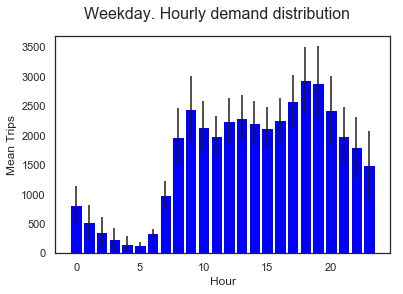

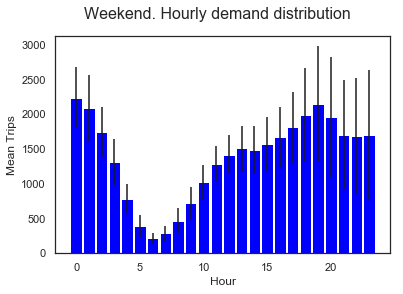

In [57]:
plot_hourly_demand(weekend = False)
plot_hourly_demand(weekend = True)

**Car demand and availability per Area and Time of day**

Demand for trips also behaves differently not only depending on the hour, but also on the city area we focus on. In the below plots, we can see which areas are more active at different times and which destinations are more common. For instance, people leaving from Loop are more likely to go to the Near North Side. Nevertheless, between 08:00AM and 09:00AM, trips leaving from Loop are very likely to end inside Loop as well.

![Hourly Demand](../imgs/hourly_areas.gif "Hourly Demand")

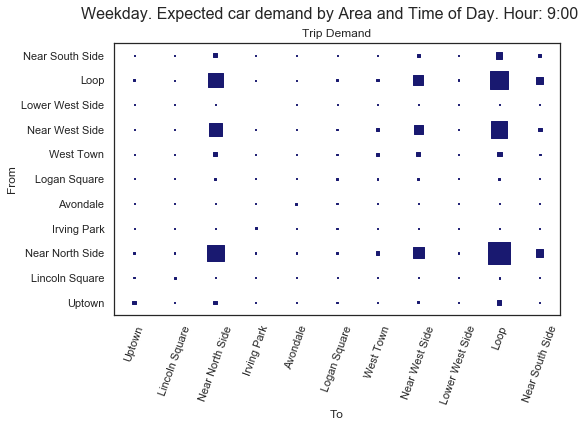

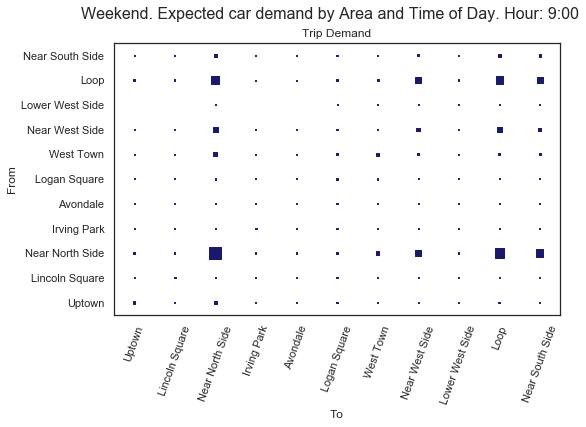

In [59]:
plot_route_demand(hour = 9, weekend = False)
plot_route_demand(hour = 9, weekend = True)

**Markov Process**<br>
This behavior seems consistent with what in statistics would be called a Markov Chain. In other words, the probability of a car's destination can be modeled based on where a trip begins and the time of the day.

Using this information, is posible to build a model that simulates the daily operation showing which areas can present problems, such as a demand larger than the amount of cars available and at what time this would happen. Moreover, we could also model and hypothesize experiments to estimate new scenarios and their impact in service before rolling out live tests that might affect the users.

Below, we can see how during most of the day in the Near North Side, more people leave than those who arrive, while by Loop area, we would expect more cars being dropped-off than picked-up during the morning and opposite to the afternoon when there would normally be a lack of available cars.

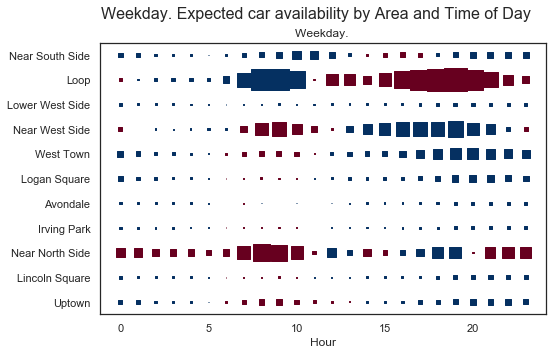

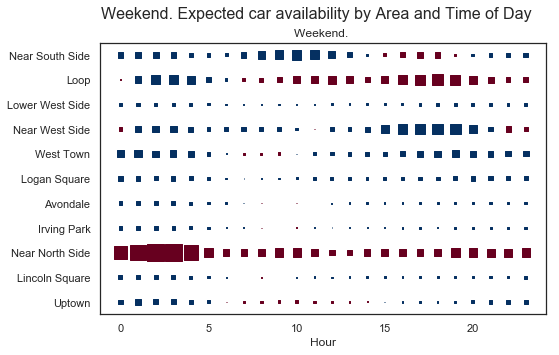

In [211]:
plot_hourly_availability(weekend = False)
plot_hourly_availability(weekend = True)

Although this view gives us a good idea of what to expect, it is static. Moreover, it isn't telling us much about the business and the KPIs that matter. For that, we should run a simulation.

## Simulating the Car-Sharing operation

The idea of this post is not to get technical about the details behind the stochastic model or the transition matrices that were built to enable the simulation. However, remember to drop me a message if you want me to let you know when the notebook with the code is uploaded.

This model tries to capture the population transportation patterns, which, as mentioned before, differ depending on factors such as the time of day, whether it's a weekday or a weekend, and where the trip begins. As our data is rounded to 15 minutes intervals, we will use this value as our time windows for the simulation. That is, the simulation will move in steps of 15 minutes. Also, in order to keep thing simple, some rules and assumptions have been made. It is possible to increase accuracy on many levels, however, increasing the complexity of the model would also increase the computation time for each simulation.

Finally, keep in mind that the purpose of this model is not to predict future demand but rather, to simulate how a given demand would behave and its impact on the daily operation of the company. In order to predict demand, other techniques such as time series forecasting could be applied, but this would be a different problem.

**Business Rules and Assumptions**

* **Demand definition:** Every time a user checks the app with the intention to book a car.
* **Daily demand:**
    * Weekdays: 1,970 trips
    * Weekends: 1,660 trips
    * **Why these values?** As explained before, the purpose is to model the operation, not to predict demand. Therefore, the model can take any forecasted input. The reason I'm choosing these values to run the model is because they represent nearly 5% of the taxi daily trips between the areas participating in the pilot.
* **Price/min:** \$0.41 (Fee charged to the user)
* **Cost/min:** \$0.2 (Variable operating cost)
* **Car autonomy:** 300 Km (Distance the car can work on one full charge)
* **Minimum battery level:** 10% (Battery level at which the car is locked until charged again) 
* **Time to full charge:** 5 hours 
    * At this point, the model does not account for transportation to a charging station.
    * It is assumed that the car remains locked at the location where the last trip ended until full charge.
    * Future versions could charging stations, their locations, and its impact on profitability.
* **Car Location:**
    * Before the first day of operation begins, the cars will be located on a way that optimizes the expected revenue based on where the demand will be expected. 
    * Two scenarios will be tested, one where no cars will be relocated by the company during the day, and one where the cars will be relocated under certain conditions.
* **Relocation time:** 35 minutes (Time it takes to relocate a car to a new area)
* **Parking time:** Normally distributed with a mean of 10 minutes and a standard deviation of 3.
    * Unlike on taxi trips, after the user arrives at the destination, he or she has to find a place to park the car.
* **Dead time:** Normally distributed with a mean of 14 minutes and a standard deviation of 5.
    * Unlike on taxi trips, when a user books a car, she has to walk all the way to where the car is parked.
    * During this "dead time", the user is not being charged.

### Scenario 1. No car relocation.

In [356]:
consolidated_reports_S1 = run_multiple_simulations(simulations_to_run = 10, days = 30, number_of_cars = 500, 
                                                   weekday_matrices = weekday_matrices,weekend_matrices = weekend_matrices,print_every_day = 1, 
                                                   weekday_demand = 1970, weekend_demand = 1660,car_relocation = 0, max_daily_relocation = 0)
map_day_cars_simulation(consolidated_reports_S1['area_report']).to_csv('../processed_data/carto_s01_no_relocation.csv',index=False)
with open('../processed_data/consolidated_reports_S1.pkl', 'wb') as handle:
    pickle.dump(consolidated_reports_S1, handle)

________________________________________________
Simulation 1
Day 1, Weekday. Trips made: 1963 | Trips Lost: 1 | Cars relocated: 0
Cummulative: Trip Count: 1963 | Lost Count: 1 | Relocations: 0
Current location of cars: Counter({2: 105, 6: 93, 9: 83, 7: 78, 10: 51, -1: 37, 5: 24, 8: 13, 0: 6, 3: 4, 4: 3, 1: 3})
---------------------------------------------------------------------
Day 2, Weekday. Trips made: 1938 | Trips Lost: 26 | Cars relocated: 0
Cummulative: Trip Count: 3901 | Lost Count: 27 | Relocations: 0
Current location of cars: Counter({6: 139, 7: 118, 10: 93, 5: 51, -1: 44, 8: 20, 0: 11, 4: 9, 1: 7, 3: 7, 9: 1})
---------------------------------------------------------------------
Day 3, Weekday. Trips made: 1556 | Trips Lost: 408 | Cars relocated: 0
Cummulative: Trip Count: 5457 | Lost Count: 435 | Relocations: 0
Current location of cars: Counter({6: 158, 10: 91, 7: 76, 5: 75, -1: 32, 8: 25, 1: 13, 4: 12, 0: 11, 3: 7})
--------------------------------------------------------

Day 28, Weekend. Trips made: 672 | Trips Lost: 983 | Cars relocated: 0
Cummulative: Trip Count: 26989 | Lost Count: 25531 | Relocations: 0
Current location of cars: Counter({5: 162, 8: 149, 4: 61, 3: 53, 1: 51, -1: 20, 10: 3, 6: 1})
---------------------------------------------------------------------
Day 29, Weekday. Trips made: 501 | Trips Lost: 1463 | Cars relocated: 0
Cummulative: Trip Count: 27490 | Lost Count: 26994 | Relocations: 0
Current location of cars: Counter({5: 169, 8: 151, 4: 62, 1: 52, 3: 52, -1: 14})
---------------------------------------------------------------------
Day 30, Weekday. Trips made: 234 | Trips Lost: 1730 | Cars relocated: 0
Cummulative: Trip Count: 27724 | Lost Count: 28724 | Relocations: 0
Current location of cars: Counter({5: 167, 8: 150, 4: 68, 3: 53, 1: 50, -1: 8, 0: 2, 10: 2})
---------------------------------------------------------------------
________________________________________________
Simulation 2
Day 1, Weekday. Trips made: 1957 | Trips 

Day 24, Weekday. Trips made: 571 | Trips Lost: 1393 | Cars relocated: 0
Cummulative: Trip Count: 25495 | Lost Count: 19787 | Relocations: 0
Current location of cars: Counter({5: 174, 8: 152, 4: 76, 1: 38, 3: 32, -1: 15, 0: 7, 6: 6})
---------------------------------------------------------------------
Day 25, Weekday. Trips made: 514 | Trips Lost: 1450 | Cars relocated: 0
Cummulative: Trip Count: 26009 | Lost Count: 21237 | Relocations: 0
Current location of cars: Counter({5: 175, 8: 154, 4: 78, 1: 40, 3: 32, -1: 17, 0: 3, 10: 1})
---------------------------------------------------------------------
Day 26, Weekday. Trips made: 453 | Trips Lost: 1511 | Cars relocated: 0
Cummulative: Trip Count: 26462 | Lost Count: 22748 | Relocations: 0
Current location of cars: Counter({5: 168, 8: 157, 4: 78, 1: 42, 3: 33, -1: 19, 0: 3})
---------------------------------------------------------------------
Day 27, Weekend. Trips made: 531 | Trips Lost: 1124 | Cars relocated: 0
Cummulative: Trip Count:

Day 21, Weekend. Trips made: 652 | Trips Lost: 1003 | Cars relocated: 0
Cummulative: Trip Count: 23063 | Lost Count: 16327 | Relocations: 0
Current location of cars: Counter({5: 204, 8: 117, 4: 76, 3: 36, 1: 35, -1: 27, 6: 2, 7: 1, 10: 1, 9: 1})
---------------------------------------------------------------------
Day 22, Weekday. Trips made: 567 | Trips Lost: 1397 | Cars relocated: 0
Cummulative: Trip Count: 23630 | Lost Count: 17724 | Relocations: 0
Current location of cars: Counter({5: 201, 8: 123, 4: 77, 3: 39, 1: 37, -1: 22, 7: 1})
---------------------------------------------------------------------
Day 23, Weekday. Trips made: 544 | Trips Lost: 1420 | Cars relocated: 0
Cummulative: Trip Count: 24174 | Lost Count: 19144 | Relocations: 0
Current location of cars: Counter({5: 204, 8: 128, 4: 78, 3: 37, 1: 35, -1: 15, 7: 2, 0: 1})
---------------------------------------------------------------------
Day 24, Weekday. Trips made: 309 | Trips Lost: 1655 | Cars relocated: 0
Cummulative:

Day 18, Weekday. Trips made: 700 | Trips Lost: 1264 | Cars relocated: 0
Cummulative: Trip Count: 20375 | Lost Count: 13741 | Relocations: 0
Current location of cars: Counter({5: 163, 8: 111, 6: 83, 4: 42, 1: 40, 3: 34, -1: 20, 0: 4, 10: 3})
---------------------------------------------------------------------
Day 19, Weekday. Trips made: 748 | Trips Lost: 1216 | Cars relocated: 0
Cummulative: Trip Count: 21123 | Lost Count: 14957 | Relocations: 0
Current location of cars: Counter({5: 169, 8: 111, 6: 67, 4: 44, 1: 39, 3: 34, -1: 31, 10: 3, 0: 1, 7: 1})
---------------------------------------------------------------------
Day 20, Weekend. Trips made: 909 | Trips Lost: 746 | Cars relocated: 0
Cummulative: Trip Count: 22032 | Lost Count: 15703 | Relocations: 0
Current location of cars: Counter({5: 164, 8: 118, -1: 47, 4: 47, 1: 43, 6: 40, 3: 36, 10: 3, 9: 2})
---------------------------------------------------------------------
Day 21, Weekend. Trips made: 911 | Trips Lost: 744 | Cars relo

Day 15, Weekday. Trips made: 912 | Trips Lost: 1052 | Cars relocated: 0
Cummulative: Trip Count: 17832 | Lost Count: 10392 | Relocations: 0
Current location of cars: Counter({5: 163, 8: 115, 4: 65, 6: 61, 1: 36, -1: 29, 3: 27, 10: 4})
---------------------------------------------------------------------
Day 16, Weekday. Trips made: 760 | Trips Lost: 1204 | Cars relocated: 0
Cummulative: Trip Count: 18592 | Lost Count: 11596 | Relocations: 0
Current location of cars: Counter({5: 169, 8: 117, 4: 69, 6: 49, 1: 36, 3: 31, -1: 27, 10: 2})
---------------------------------------------------------------------
Day 17, Weekday. Trips made: 698 | Trips Lost: 1266 | Cars relocated: 0
Cummulative: Trip Count: 19290 | Lost Count: 12862 | Relocations: 0
Current location of cars: Counter({5: 175, 8: 120, 4: 70, 6: 38, 1: 36, 3: 31, -1: 21, 0: 7, 2: 1, 10: 1})
---------------------------------------------------------------------
Day 18, Weekday. Trips made: 721 | Trips Lost: 1243 | Cars relocated: 0
C

Day 12, Weekday. Trips made: 732 | Trips Lost: 1232 | Cars relocated: 0
Cummulative: Trip Count: 15363 | Lost Count: 7587 | Relocations: 0
Current location of cars: Counter({6: 140, 5: 133, 8: 89, 4: 44, 3: 31, 1: 31, -1: 24, 10: 5, 2: 2, 0: 1})
---------------------------------------------------------------------
Day 13, Weekend. Trips made: 950 | Trips Lost: 705 | Cars relocated: 0
Cummulative: Trip Count: 16313 | Lost Count: 8292 | Relocations: 0
Current location of cars: Counter({5: 137, 6: 114, 8: 91, 4: 47, -1: 38, 3: 32, 1: 28, 0: 6, 2: 4, 7: 2, 10: 1})
---------------------------------------------------------------------
Day 14, Weekend. Trips made: 958 | Trips Lost: 697 | Cars relocated: 0
Cummulative: Trip Count: 17271 | Lost Count: 8989 | Relocations: 0
Current location of cars: Counter({5: 147, 8: 97, 6: 84, 4: 54, -1: 39, 3: 32, 1: 31, 0: 13, 2: 2, 9: 1})
---------------------------------------------------------------------
Day 15, Weekday. Trips made: 1058 | Trips Lost: 9

Day 9, Weekday. Trips made: 925 | Trips Lost: 1039 | Cars relocated: 0
Cummulative: Trip Count: 12451 | Lost Count: 4607 | Relocations: 0
Current location of cars: Counter({6: 192, 5: 117, 8: 63, -1: 41, 4: 26, 3: 22, 1: 17, 10: 17, 0: 3, 7: 2})
---------------------------------------------------------------------
Day 10, Weekday. Trips made: 1072 | Trips Lost: 892 | Cars relocated: 0
Cummulative: Trip Count: 13523 | Lost Count: 5499 | Relocations: 0
Current location of cars: Counter({6: 192, 5: 126, 8: 70, 4: 31, -1: 23, 1: 22, 3: 21, 10: 7, 9: 4, 0: 4})
---------------------------------------------------------------------
Day 11, Weekday. Trips made: 803 | Trips Lost: 1161 | Cars relocated: 0
Cummulative: Trip Count: 14326 | Lost Count: 6660 | Relocations: 0
Current location of cars: Counter({6: 182, 5: 132, 8: 77, 4: 30, -1: 28, 1: 24, 3: 19, 0: 5, 10: 3})
---------------------------------------------------------------------
Day 12, Weekday. Trips made: 895 | Trips Lost: 1069 | Cars

Day 6, Weekend. Trips made: 1066 | Trips Lost: 589 | Cars relocated: 0
Cummulative: Trip Count: 9579 | Lost Count: 1896 | Relocations: 0
Current location of cars: Counter({6: 147, 5: 103, 10: 73, -1: 50, 8: 45, 0: 25, 4: 23, 3: 12, 7: 12, 1: 10})
---------------------------------------------------------------------
Day 7, Weekend. Trips made: 1174 | Trips Lost: 481 | Cars relocated: 0
Cummulative: Trip Count: 10753 | Lost Count: 2377 | Relocations: 0
Current location of cars: Counter({6: 139, 5: 101, 10: 70, 8: 57, -1: 44, 4: 31, 1: 18, 3: 14, 0: 13, 2: 12, 9: 1})
---------------------------------------------------------------------
Day 8, Weekday. Trips made: 1105 | Trips Lost: 859 | Cars relocated: 0
Cummulative: Trip Count: 11858 | Lost Count: 3236 | Relocations: 0
Current location of cars: Counter({6: 160, 5: 112, 8: 62, 10: 57, 4: 36, -1: 26, 1: 16, 3: 15, 0: 10, 9: 3, 7: 3})
---------------------------------------------------------------------
Day 9, Weekday. Trips made: 1038 | T

Day 2, Weekday. Trips made: 1893 | Trips Lost: 71 | Cars relocated: 0
Cummulative: Trip Count: 3857 | Lost Count: 71 | Relocations: 0
Current location of cars: Counter({6: 136, 7: 111, 10: 68, -1: 52, 5: 46, 2: 26, 8: 22, 0: 13, 4: 12, 9: 8, 1: 3, 3: 3})
---------------------------------------------------------------------
Day 3, Weekday. Trips made: 1637 | Trips Lost: 327 | Cars relocated: 0
Cummulative: Trip Count: 5494 | Lost Count: 398 | Relocations: 0
Current location of cars: Counter({6: 158, 10: 86, 7: 80, 5: 60, -1: 42, 8: 28, 0: 18, 4: 12, 1: 7, 2: 4, 3: 3, 9: 2})
---------------------------------------------------------------------
Day 4, Weekday. Trips made: 1488 | Trips Lost: 476 | Cars relocated: 0
Cummulative: Trip Count: 6982 | Lost Count: 874 | Relocations: 0
Current location of cars: Counter({6: 175, 10: 87, 5: 81, 7: 42, -1: 38, 8: 38, 0: 13, 4: 12, 1: 8, 3: 6})
---------------------------------------------------------------------
Day 5, Weekday. Trips made: 1401 | Tr

Day 29, Weekday. Trips made: 554 | Trips Lost: 1410 | Cars relocated: 0
Cummulative: Trip Count: 28711 | Lost Count: 25773 | Relocations: 0
Current location of cars: Counter({8: 160, 5: 155, 4: 85, 1: 45, 3: 35, -1: 14, 0: 3, 10: 3})
---------------------------------------------------------------------
Day 30, Weekday. Trips made: 467 | Trips Lost: 1497 | Cars relocated: 0
Cummulative: Trip Count: 29178 | Lost Count: 27270 | Relocations: 0
Current location of cars: Counter({8: 162, 5: 151, 4: 85, 1: 49, 3: 34, -1: 16, 0: 2, 10: 1})
---------------------------------------------------------------------
________________________________________________
Simulation 10
Day 1, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 0
Cummulative: Trip Count: 1961 | Lost Count: 3 | Relocations: 0
Current location of cars: Counter({2: 108, 7: 87, 9: 86, 6: 69, -1: 51, 10: 48, 5: 29, 8: 14, 4: 4, 1: 2, 3: 2})
---------------------------------------------------------------------
Day 2, Weekday

Day 26, Weekday. Trips made: 305 | Trips Lost: 1659 | Cars relocated: 0
Cummulative: Trip Count: 25021 | Lost Count: 24189 | Relocations: 0
Current location of cars: Counter({5: 178, 8: 143, 4: 73, 3: 48, 1: 45, -1: 12, 0: 1})
---------------------------------------------------------------------
Day 27, Weekend. Trips made: 490 | Trips Lost: 1165 | Cars relocated: 0
Cummulative: Trip Count: 25511 | Lost Count: 25354 | Relocations: 0
Current location of cars: Counter({5: 160, 8: 144, 4: 76, 3: 52, 1: 42, -1: 25, 10: 1})
---------------------------------------------------------------------
Day 28, Weekend. Trips made: 732 | Trips Lost: 923 | Cars relocated: 0
Cummulative: Trip Count: 26243 | Lost Count: 26277 | Relocations: 0
Current location of cars: Counter({8: 147, 5: 144, 4: 81, 3: 50, 1: 38, -1: 37, 0: 2, 10: 1})
---------------------------------------------------------------------
Day 29, Weekday. Trips made: 697 | Trips Lost: 1267 | Cars relocated: 0
Cummulative: Trip Count: 26940

![Simulation without relocation](../imgs/simulation_no_relocation.gif "Simulation 1")

Running 10 simulations for 30 days yielded the following results:

#### Car Availability: 

When no action is taken regarding relocation, car availability is affected right from the first day in areas with important demand, such as Near South Side, Irving Park, and Near North Side. These same areas, which had enough car availability at the beginning, quickly run out of available cars which begin to accumulate in areas with less demand, such as Loop and West Town.

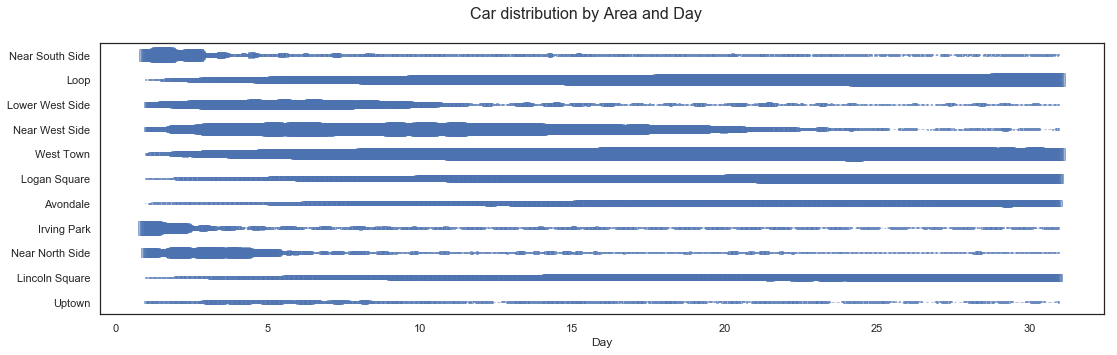

In [606]:
plot_car_area_distribution(consolidated_reports_S1, com_areas)

The fact that cars are not being found by the users translates into losses as by the end of the month, over 1,000 daily trips are lost.

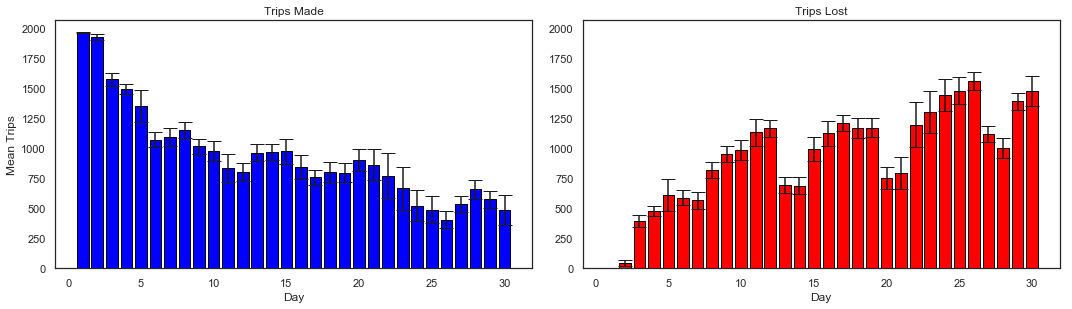

In [359]:
plot_daily_trips(consolidated_reports_S1['trips_report'], consolidated_reports_S1['trips_lost_report'])

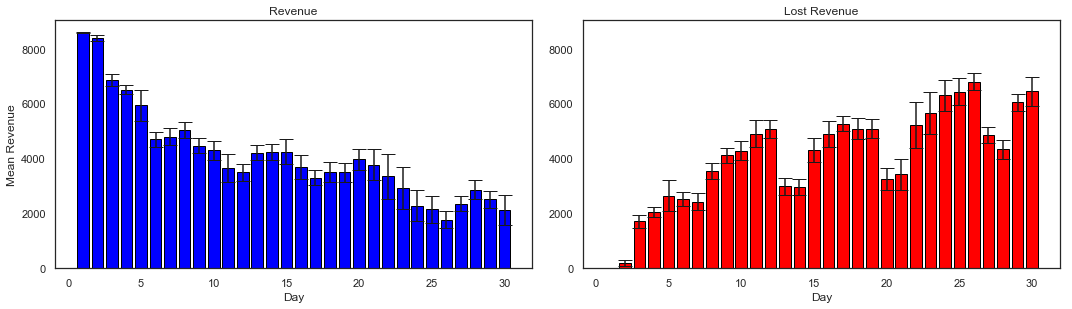

In [360]:
plot_daily_revenue(consolidated_reports_S1['trips_report'], consolidated_reports_S1['trips_lost_report'])

When looking at the amount of trips made and lost per Area, we see that areas such as Irving Park are losing more trips than they are making, while areas that are concentrating large amounts of cars, such as Loop, barely start any trip.

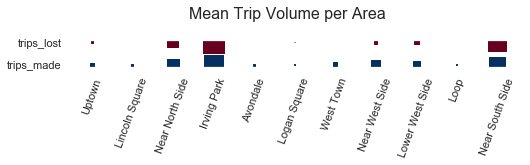

In [763]:
trips_per_area(consolidated_reports_S1)

#### Business Metrics

As expected, business metrics don't look impressive at all. I don't know much about the industry, but I can certainly say that when only 50% of the times a user needs a car, that demand gets served, these users are not going to be there for much longer. It could also be said that the other metrics look pretty bad as well. However, without knowing the industry standards that would only be a hypothesis for now. Nevertheless, running a simulation that includes car relocation would give us something to compare.

In [670]:
business_metrics_report(consolidated_reports_S1, cars = 500, print_results=True)

Average daily traveled distance:               1610.35
Average daily trip profit:                     4113.20
Average daily trips:                            939.79
Average daily trips per car:                      1.88
Average daily profit per car:                     8.23
Average profit per trip:                          4.38
Average trips lost per day:                     947.92
Average potential revenue lost per day:        4119.18
Average demand served:                           49.78%


,mean_daily_values
distance_miles,1610.346096
trip_profit,4113.197353
trips,939.790000
minutes,19586.654064
trips_lost,947.923218
lost_profit,4119.184877
relocations,0.000000
relocated_miles,0.000000
relocation_cost,0.000000
trips_per_car,1.879580


### Scenario 2

With some tweaks to the model, different scenarios can be tested. For instance, let's imagine (for the sake of simplicity) that the marketing department has an idea to solve the relocation problem, they now need the operations department to run the model simulating an implementation of this idea and their assumptions.

**New conditions:**
* A promotion, through a push notification, is sent twice a day at 07:00AM and 04:00PM. A couple hours before the morning and afternoon peak times.
* The promotion is only sent to areas where an excess of cars can be found at that time (more cars than the projected demand during the following 4 hours).
* Under this promotion, users picking up cars at this areas can ride for free, as long as the trip ends in pre-defined areas. Specifically, areas where demand is projected to be greater than the available cars  within the following 4 hours. This way, the company would be outsourcing the relocation to its users.
* It is assumed that the free ride would be a strong enough incentive so many users who normally would take another mean of transportation at these hours would now use the car-sharing option. Furthermore, even new users who wouldn't normally use the service might join just to travel for free during these hours.
* It is assumed that between 200 and 300 cars can be relocated daily this way.

In [357]:
consolidated_reports_S2 = run_multiple_simulations(simulations_to_run = 10, days = 30, number_of_cars = 500, 
                                                   weekday_matrices = weekday_matrices,weekend_matrices = weekend_matrices,print_every_day = 1, 
                                                   weekday_demand = 1970, weekend_demand = 1660,car_relocation = 1, max_daily_relocation = 260)
map_day_cars_simulation(consolidated_reports_S2['area_report']).to_csv('../processed_data/carto_s02_relocation.csv',index=False)
with open('../processed_data/consolidated_reports_S2.pkl', 'wb') as handle:
    pickle.dump(consolidated_reports_S2, handle)

________________________________________________
Simulation 1
Day 1, Weekday. Trips made: 1958 | Trips Lost: 6 | Cars relocated: 36
Cummulative: Trip Count: 1958 | Lost Count: 6 | Relocations: 36
Current location of cars: Counter({2: 123, 7: 115, 9: 83, 6: 60, -1: 57, 10: 26, 5: 13, 8: 8, 0: 6, 4: 4, 1: 3, 3: 2})
---------------------------------------------------------------------
Day 2, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 143
Cummulative: Trip Count: 3919 | Lost Count: 9 | Relocations: 179
Current location of cars: Counter({2: 166, 7: 136, 6: 47, 9: 43, -1: 40, 10: 30, 5: 21, 0: 9, 4: 4, 8: 3, 3: 1})
---------------------------------------------------------------------
Day 3, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 147
Cummulative: Trip Count: 5880 | Lost Count: 12 | Relocations: 326
Current location of cars: Counter({2: 167, 7: 111, 6: 50, -1: 45, 9: 41, 10: 39, 5: 25, 0: 15, 8: 6, 4: 1})
---------------------------------------------------

Day 26, Weekday. Trips made: 1964 | Trips Lost: 0 | Cars relocated: 195
Cummulative: Trip Count: 49113 | Lost Count: 97 | Relocations: 4408
Current location of cars: Counter({2: 148, 7: 133, 6: 58, 9: 40, 10: 39, -1: 38, 5: 24, 8: 7, 0: 5, 3: 4, 1: 3, 4: 1})
---------------------------------------------------------------------
Day 27, Weekend. Trips made: 1655 | Trips Lost: 0 | Cars relocated: 130
Cummulative: Trip Count: 50768 | Lost Count: 97 | Relocations: 4538
Current location of cars: Counter({7: 102, 2: 86, 6: 80, 10: 62, 5: 52, -1: 49, 8: 19, 9: 19, 0: 9, 1: 8, 4: 8, 3: 6})
---------------------------------------------------------------------
Day 28, Weekend. Trips made: 1575 | Trips Lost: 80 | Cars relocated: 146
Cummulative: Trip Count: 52343 | Lost Count: 177 | Relocations: 4684
Current location of cars: Counter({7: 102, 6: 69, 2: 67, 10: 64, 5: 55, -1: 49, 8: 32, 4: 17, 9: 12, 1: 12, 3: 11, 0: 10})
---------------------------------------------------------------------
Day 29,

Day 21, Weekend. Trips made: 1655 | Trips Lost: 0 | Cars relocated: 154
Cummulative: Trip Count: 39348 | Lost Count: 42 | Relocations: 3383
Current location of cars: Counter({2: 95, 7: 91, 10: 61, 6: 55, -1: 50, 0: 30, 8: 26, 9: 25, 5: 25, 4: 21, 1: 11, 3: 10})
---------------------------------------------------------------------
Day 22, Weekday. Trips made: 1963 | Trips Lost: 1 | Cars relocated: 241
Cummulative: Trip Count: 41311 | Lost Count: 43 | Relocations: 3624
Current location of cars: Counter({2: 159, 7: 114, 6: 56, 9: 48, 10: 41, -1: 40, 5: 22, 0: 8, 1: 4, 3: 4, 8: 3, 4: 1})
---------------------------------------------------------------------
Day 23, Weekday. Trips made: 1962 | Trips Lost: 2 | Cars relocated: 167
Cummulative: Trip Count: 43273 | Lost Count: 45 | Relocations: 3791
Current location of cars: Counter({2: 131, 7: 126, 6: 71, 9: 56, 10: 41, -1: 36, 5: 16, 0: 10, 8: 5, 1: 5, 4: 2, 3: 1})
---------------------------------------------------------------------
Day 24, W

Day 16, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 226
Cummulative: Trip Count: 30140 | Lost Count: 48 | Relocations: 2711
Current location of cars: Counter({2: 205, 7: 93, 6: 59, 10: 43, -1: 36, 9: 22, 5: 21, 8: 9, 0: 6, 4: 5, 1: 1})
---------------------------------------------------------------------
Day 17, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 171
Cummulative: Trip Count: 32101 | Lost Count: 51 | Relocations: 2882
Current location of cars: Counter({2: 164, 7: 105, 6: 79, 9: 52, -1: 40, 10: 19, 5: 19, 0: 8, 1: 7, 8: 5, 3: 2})
---------------------------------------------------------------------
Day 18, Weekday. Trips made: 1960 | Trips Lost: 4 | Cars relocated: 134
Cummulative: Trip Count: 34061 | Lost Count: 55 | Relocations: 3016
Current location of cars: Counter({2: 165, 7: 106, 6: 63, 10: 44, -1: 43, 9: 38, 5: 24, 8: 7, 0: 6, 1: 3, 3: 1})
---------------------------------------------------------------------
Day 19, Weekday. Trips made: 196

Day 11, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 151
Cummulative: Trip Count: 20951 | Lost Count: 35 | Relocations: 1750
Current location of cars: Counter({2: 141, 7: 129, 9: 67, 6: 50, -1: 34, 10: 33, 5: 23, 8: 10, 1: 5, 0: 5, 4: 3})
---------------------------------------------------------------------
Day 12, Weekday. Trips made: 1962 | Trips Lost: 2 | Cars relocated: 174
Cummulative: Trip Count: 22913 | Lost Count: 37 | Relocations: 1924
Current location of cars: Counter({2: 161, 7: 141, -1: 50, 6: 46, 5: 32, 10: 26, 9: 23, 0: 9, 8: 6, 4: 3, 1: 3})
---------------------------------------------------------------------
Day 13, Weekend. Trips made: 1654 | Trips Lost: 1 | Cars relocated: 130
Cummulative: Trip Count: 24567 | Lost Count: 38 | Relocations: 2054
Current location of cars: Counter({7: 100, 2: 97, 6: 65, -1: 55, 10: 51, 5: 47, 9: 26, 8: 16, 0: 15, 1: 11, 4: 10, 3: 7})
---------------------------------------------------------------------
Day 14, Weekend. Trip

Day 6, Weekend. Trips made: 1655 | Trips Lost: 0 | Cars relocated: 130
Cummulative: Trip Count: 11466 | Lost Count: 9 | Relocations: 925
Current location of cars: Counter({7: 95, 2: 83, 6: 80, 10: 63, -1: 52, 5: 43, 9: 35, 0: 12, 8: 11, 4: 11, 1: 8, 3: 7})
---------------------------------------------------------------------
Day 7, Weekend. Trips made: 1632 | Trips Lost: 23 | Cars relocated: 169
Cummulative: Trip Count: 13098 | Lost Count: 32 | Relocations: 1094
Current location of cars: Counter({7: 91, 6: 80, 10: 68, 2: 68, -1: 58, 5: 33, 8: 28, 4: 23, 0: 22, 3: 15, 1: 9, 9: 5})
---------------------------------------------------------------------
Day 8, Weekday. Trips made: 1964 | Trips Lost: 0 | Cars relocated: 260
Cummulative: Trip Count: 15062 | Lost Count: 32 | Relocations: 1354
Current location of cars: Counter({2: 129, 7: 96, 6: 66, 9: 55, -1: 50, 10: 37, 0: 20, 5: 15, 8: 11, 4: 9, 3: 6, 1: 6})
---------------------------------------------------------------------
Day 9, Weekday

Day 1, Weekday. Trips made: 1957 | Trips Lost: 7 | Cars relocated: 72
Cummulative: Trip Count: 1957 | Lost Count: 7 | Relocations: 72
Current location of cars: Counter({2: 136, 7: 120, 9: 77, 6: 64, -1: 44, 10: 29, 5: 19, 0: 6, 8: 2, 3: 2, 1: 1})
---------------------------------------------------------------------
Day 2, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 173
Cummulative: Trip Count: 3918 | Lost Count: 10 | Relocations: 245
Current location of cars: Counter({2: 162, 7: 104, 6: 76, -1: 53, 9: 51, 10: 23, 5: 18, 0: 7, 8: 4, 1: 2})
---------------------------------------------------------------------
Day 3, Weekday. Trips made: 1964 | Trips Lost: 0 | Cars relocated: 158
Cummulative: Trip Count: 5882 | Lost Count: 10 | Relocations: 403
Current location of cars: Counter({2: 160, 7: 133, 6: 61, -1: 52, 9: 33, 10: 32, 5: 15, 0: 6, 8: 3, 4: 2, 3: 2, 1: 1})
---------------------------------------------------------------------
Day 4, Weekday. Trips made: 1963 | Trips Lo

Day 27, Weekend. Trips made: 1645 | Trips Lost: 10 | Cars relocated: 130
Cummulative: Trip Count: 50773 | Lost Count: 92 | Relocations: 4462
Current location of cars: Counter({7: 106, 2: 79, 6: 78, 10: 68, -1: 62, 5: 38, 9: 31, 8: 16, 4: 7, 3: 6, 1: 5, 0: 4})
---------------------------------------------------------------------
Day 28, Weekend. Trips made: 1655 | Trips Lost: 0 | Cars relocated: 186
Cummulative: Trip Count: 52428 | Lost Count: 92 | Relocations: 4648
Current location of cars: Counter({7: 98, 2: 76, 10: 71, -1: 70, 6: 64, 5: 41, 8: 23, 0: 19, 4: 16, 3: 9, 9: 7, 1: 6})
---------------------------------------------------------------------
Day 29, Weekday. Trips made: 1963 | Trips Lost: 1 | Cars relocated: 260
Cummulative: Trip Count: 54391 | Lost Count: 93 | Relocations: 4908
Current location of cars: Counter({2: 168, 7: 96, 9: 59, 6: 53, -1: 52, 10: 25, 5: 17, 0: 13, 8: 9, 4: 4, 3: 2, 1: 2})
---------------------------------------------------------------------
Day 30, Week

Day 22, Weekday. Trips made: 1959 | Trips Lost: 5 | Cars relocated: 247
Cummulative: Trip Count: 41281 | Lost Count: 73 | Relocations: 3701
Current location of cars: Counter({2: 169, 7: 101, 6: 63, 9: 45, 10: 43, -1: 37, 5: 20, 0: 8, 8: 7, 4: 5, 1: 2})
---------------------------------------------------------------------
Day 23, Weekday. Trips made: 1962 | Trips Lost: 2 | Cars relocated: 160
Cummulative: Trip Count: 43243 | Lost Count: 75 | Relocations: 3861
Current location of cars: Counter({2: 206, 7: 93, 6: 61, -1: 40, 9: 35, 10: 27, 5: 21, 8: 6, 1: 4, 0: 4, 3: 2, 4: 1})
---------------------------------------------------------------------
Day 24, Weekday. Trips made: 1956 | Trips Lost: 8 | Cars relocated: 139
Cummulative: Trip Count: 45199 | Lost Count: 83 | Relocations: 4000
Current location of cars: Counter({2: 175, 7: 94, 9: 61, 6: 55, -1: 46, 10: 25, 5: 22, 8: 8, 1: 4, 4: 4, 0: 4, 3: 2})
---------------------------------------------------------------------
Day 25, Weekday. Trip

Day 17, Weekday. Trips made: 1962 | Trips Lost: 2 | Cars relocated: 158
Cummulative: Trip Count: 32092 | Lost Count: 60 | Relocations: 2753
Current location of cars: Counter({7: 143, 2: 139, 6: 58, -1: 42, 9: 32, 10: 32, 5: 28, 0: 16, 8: 5, 1: 4, 3: 1})
---------------------------------------------------------------------
Day 18, Weekday. Trips made: 1962 | Trips Lost: 2 | Cars relocated: 177
Cummulative: Trip Count: 34054 | Lost Count: 62 | Relocations: 2930
Current location of cars: Counter({7: 156, 2: 150, 6: 73, -1: 48, 10: 23, 9: 23, 5: 9, 0: 8, 8: 5, 3: 2, 1: 2, 4: 1})
---------------------------------------------------------------------
Day 19, Weekday. Trips made: 1963 | Trips Lost: 1 | Cars relocated: 151
Cummulative: Trip Count: 36017 | Lost Count: 63 | Relocations: 3081
Current location of cars: Counter({2: 134, 7: 129, 6: 70, -1: 56, 10: 42, 9: 42, 5: 11, 8: 4, 4: 4, 0: 4, 3: 2, 1: 2})
---------------------------------------------------------------------
Day 20, Weekend. Tr

Day 12, Weekday. Trips made: 1964 | Trips Lost: 0 | Cars relocated: 193
Cummulative: Trip Count: 22911 | Lost Count: 39 | Relocations: 1946
Current location of cars: Counter({2: 164, 7: 122, 6: 67, -1: 54, 10: 24, 5: 22, 9: 22, 0: 13, 8: 4, 1: 3, 4: 3, 3: 2})
---------------------------------------------------------------------
Day 13, Weekend. Trips made: 1655 | Trips Lost: 0 | Cars relocated: 138
Cummulative: Trip Count: 24566 | Lost Count: 39 | Relocations: 2084
Current location of cars: Counter({2: 135, 7: 85, -1: 60, 6: 58, 10: 48, 5: 37, 0: 22, 9: 14, 8: 13, 4: 11, 1: 11, 3: 6})
---------------------------------------------------------------------
Day 14, Weekend. Trips made: 1653 | Trips Lost: 2 | Cars relocated: 130
Cummulative: Trip Count: 26219 | Lost Count: 41 | Relocations: 2214
Current location of cars: Counter({7: 75, 10: 72, 2: 69, 6: 66, -1: 51, 9: 36, 5: 35, 8: 26, 0: 25, 4: 16, 1: 16, 3: 13})
---------------------------------------------------------------------
Day 15

Day 7, Weekend. Trips made: 1655 | Trips Lost: 0 | Cars relocated: 138
Cummulative: Trip Count: 13123 | Lost Count: 7 | Relocations: 947
Current location of cars: Counter({2: 106, 7: 92, 10: 58, -1: 57, 6: 55, 5: 35, 0: 26, 8: 23, 3: 17, 9: 16, 1: 10, 4: 5})
---------------------------------------------------------------------
Day 8, Weekday. Trips made: 1961 | Trips Lost: 3 | Cars relocated: 258
Cummulative: Trip Count: 15084 | Lost Count: 10 | Relocations: 1205
Current location of cars: Counter({2: 191, 7: 96, 6: 62, -1: 50, 9: 46, 10: 23, 5: 11, 0: 7, 8: 6, 1: 6, 3: 2})
---------------------------------------------------------------------
Day 9, Weekday. Trips made: 1964 | Trips Lost: 0 | Cars relocated: 142
Cummulative: Trip Count: 17048 | Lost Count: 10 | Relocations: 1347
Current location of cars: Counter({2: 171, 7: 123, 6: 56, 9: 54, -1: 40, 10: 25, 5: 13, 0: 7, 8: 5, 4: 4, 1: 2})
---------------------------------------------------------------------
Day 10, Weekday. Trips made:

When a relocation action is taken, the cars are constantly redistributed from the areas where trips are most likely to end, to areas where demand is to be expected. This way, areas such as Loop and West Town don't accumulate cars anymore while the Near South Side, Irving Park, and Near North Side now have enough cars fo fulfill the demand during peak hours.

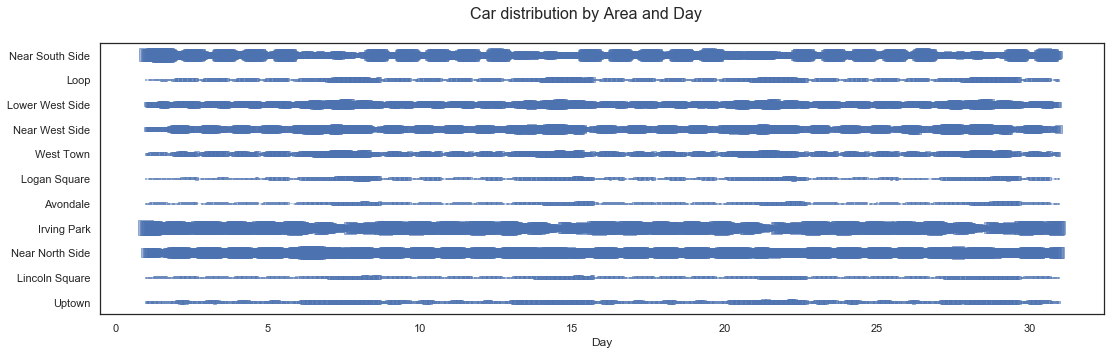

In [653]:
plot_car_area_distribution(consolidated_reports_S2, com_areas)

The mean daily trips distribution is also smoothed as now it would be more likely for a user to find available cars during peak hours.

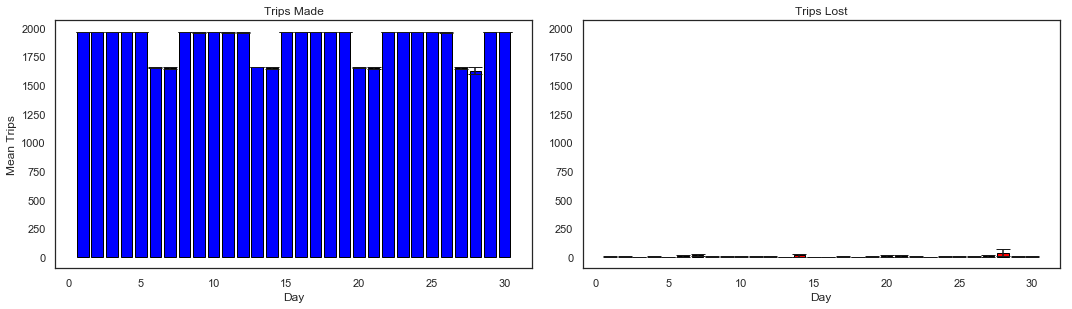

In [361]:
plot_daily_trips(consolidated_reports_S2['trips_report'], consolidated_reports_S2['trips_lost_report'])

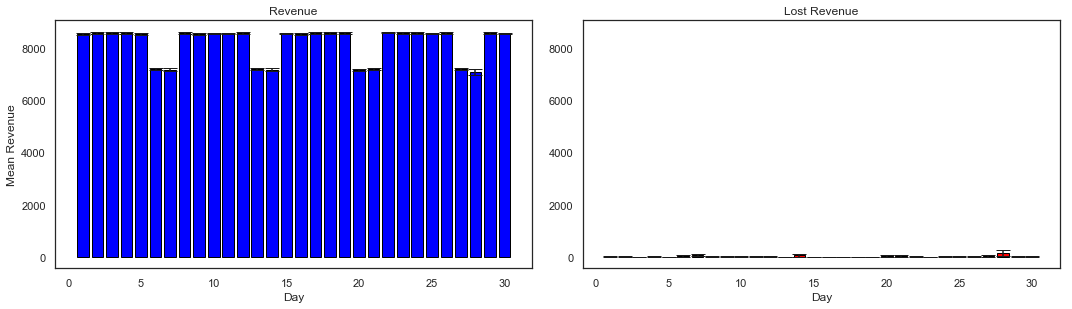

In [363]:
plot_daily_revenue(consolidated_reports_S2['trips_report'], consolidated_reports_S2['trips_lost_report'])

In this new scenario, we can see how only in the areas with the largest demand, a very small proportion of the trips is affected. It looks like if the assumptions happen to be true, both the relocation problem would be fixed, and the users would be able to use the service almost every time they need a car.

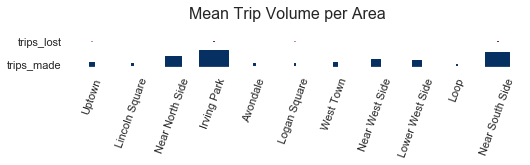

In [764]:
trips_per_area(consolidated_reports_S2)

#### Business Metrics

On the new scenario, almost 100% of the demand would be covered and daily profits would increase by 70%, from around 4,000 to 7,000, accounting for the cost of relocation. It seems the new model would make sense. 

In [671]:
business_metrics_report(consolidated_reports_S2, cars = 500)

Average daily traveled distance:               3102.02
Average daily trip profit:                     8189.35
Average daily trips:                           1877.75
Average daily trips per car:                      3.76
Average daily profit per car:                    16.38
Average profit per trip:                          4.36
Average trips lost per day:                       5.48
Average potential revenue lost per day:          25.48
Average demand served:                           99.71%
Average daily relocation cost:                 1180.15
Average daily trip profit after relocation:    7009.19
Average profit per car after relocation cost:    14.02


,mean_daily_values
distance_miles,3102.020722
trip_profit,8189.346738
trips,1877.753333
minutes,38996.889227
trips_lost,5.480492
lost_profit,25.484654
relocations,168.593333
relocated_miles,382.380653
relocation_cost,1180.153333
trips_per_car,3.755507


## Conclusions

Finally, we can even visualize where our cars be during the following days in both scenarios.  It's clear how in our first scenario cars tend to accumulate on some "absorbing" areas, while on the relocation scenario, important areas are never unattended and we can see how some areas stop accumulating vehicles.

![Simulations](../imgs/map_scenarios1_2.gif "Simulations")

We have seen how, through some data mining on third party sources we where able to build a stochastic model, we can simulate the operation of a car sharing business on a city where we have not operated so far. Of course, some assumptions have been made to simplify this example, but I'm sure you can get the idea.

The next thing to do, would be to try and gather some more data to test our assumptions (which might turn out to be too optimistic at this point), and maybe, begin some experiments and pilot tests on real users.